In [1]:
#Importing all libraries

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the HTML table from the Wikipedia page
NIFTY500 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_500')[2][3]
NIFTY500 = NIFTY500.str.replace('.', '-')
symbols = NIFTY500.unique().tolist()

symbols_list = symbols[1:]

end_date = '2023-07-13'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  501 of 501 completed

467 Failed downloads:
['BOSCHLTD', 'SJVN', 'ADANIENSOL', 'ASHOKLEY', 'ALKYLAMINE', 'ELGIEQUIP', 'HINDUNILVR', 'BLUEDART', 'GPPL', 'AMARAJABAT', 'WESTLIFE', 'MARUTI', 'KENNAMET', 'ICICIGI', 'VGUARD', 'MANKIND', 'CHALET', 'PPLPHARMA', 'RTNINDIA', 'APLAPOLLO', 'BHARATFORG', 'TTKPRESTIG', 'JSWSTEEL', 'POLYPLEX', 'ZENSARTECH', 'CESC', 'CIPLA', 'JMFINANCIL', 'TANLA', 'NIACL', 'TITAN', 'MAHLOG', 'LODHA', 'KOTAKBANK', 'PNCINFRA', 'EQUITASBNK', 'BAJAJHLDNG', 'COCHINSHIP', 'SONATSOFTW', 'JAMNAAUTO', 'SUNPHARMA', 'FDC', 'AFFLE', 'NATCOPHARM', 'BAJAJFINSV', 'BANKBARODA', 'APOLLOHOSP', 'PRINCEPIPE', 'OBEROIRLTY', 'SHOPERSTOP', 'KPRMILL', 'ASTRAL', 'INDIGOPNTS', 'CANFINHOME', 'GODREJPROP', 'NTPC', 'FIVESTAR', 'VIPIND', 'ADANIPOWER', 'NLCINDIA', 'POWERGRID', 'INDHOTEL', 'ZFCVINDIA', 'BORORENEW', 'GUJALKALI', 'TATAPOWER', 'ESCORTS', 'MHRIL', 'MEDANTA', 'MRPL', 'TATACONSUM', 'GARFIBRES', 'NSLNISP', 'JKCEMENT', 'GREENPANEL', 'DELH

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-07-15 BDL     22.957918  25.629999  25.920000  25.629999  25.820000   
           BLS      0.148800   0.148800   0.148800   0.148800   0.148800   
           CCL     44.719658  51.840000  52.259998  51.700001  52.169998   
           HAL     35.089699  41.070000  42.320000  41.060001  42.310001   
           IDEA     0.025000   0.025000   0.025000   0.025000   0.025000   
...                      ...        ...        ...        ...        ...   
2023-07-12 OIL     28.420000  28.420000  28.420000  28.420000  28.420000   
           PFC     16.666611  17.469999  17.760000  17.320000  17.410000   
           RBA     59.569309  60.349998  61.430000  60.299999  61.340000   
           TCI     35.840000  35.840000  35.900002  35.000000  35.490002   
           TCS      3.200000   3.200000   3.380000   3.200000   3.350000   

Price                  volume  
date       ticker              
2015-07-15 BDL          900.0  
           BLS            0.0  
           CCL      3569300.0  
           HAL     14552100.0  
           IDEA           0.0  
...                       ...  
2023-07-12 OIL            0.0  
           PFC       107500.0  
           RBA       742200.0  
           TCI         9800.0  
           TCS       350500.0  

[39414 rows x 6 columns]

In [3]:
#Calculating various Finance Parameters

# Calculate Garman_klass
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Calculate RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

#Calculate Bollinger Bands
def bollinger_band(price, length = 20, num_stdev = 2):
    mean_price = price.rolling(length).mean()
    stdev = price.rolling(length).std()
    upband = mean_price + num_stdev*stdev
    dwnband = mean_price - num_stdev*stdev
    
    return np.round(mean_price, 3), np.round(upband, 3), np.round(dwnband, 3)

df['bb_mid'], df['bb_high'], df['bb_low'] = bollinger_band(df['adj close'])


# Calculate ATR
def calculate_atr(df, period=14):
    # Calculate True Range (TR)
    df['tr'] = df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['close']), abs(row['low'] - row['close'])), axis=1)

    # Calculate ATR (14-day period)
    df['atr'] = df.groupby('ticker')['tr'].transform(lambda x: x.rolling(period).mean())

    return df

df = calculate_atr(df)

#Calculate MACD
def compute_macd(close):
    exp12 = close.ewm(span=12, adjust=False).mean()
    exp26 = close.ewm(span=26, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=9, adjust=False).mean()
    macd_values = macd - signal
    # Z-score Normalization
    normalized_macd = (macd_values - macd_values.mean()) / macd_values.std()
    return normalized_macd

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

#Calculate Rupees Volume
df['rupees_volume'] = (df['adj close']*df['volume'])/1e6
df

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-07-15 BDL     22.957918  25.629999  25.920000  25.629999  25.820000   
           BLS      0.148800   0.148800   0.148800   0.148800   0.148800   
           CCL     44.719658  51.840000  52.259998  51.700001  52.169998   
           HAL     35.089699  41.070000  42.320000  41.060001  42.310001   
           IDEA     0.025000   0.025000   0.025000   0.025000   0.025000   
...                      ...        ...        ...        ...        ...   
2023-07-12 OIL     28.420000  28.420000  28.420000  28.420000  28.420000   
           PFC     16.666611  17.469999  17.760000  17.320000  17.410000   
           RBA     59.569309  60.349998  61.430000  60.299999  61.340000   
           TCI     35.840000  35.840000  35.900002  35.000000  35.490002   
           TCS      3.200000   3.200000   3.380000   3.200000   3.350000   

Price                  volume  garman_klass_vol        rsi  bb_mid  bb_high  \
date       ticker                                                             
2015-07-15 BDL          900.0         -0.005269        NaN     NaN      NaN   
           BLS            0.0          0.000000        NaN     NaN      NaN   
           CCL      3569300.0         -0.009115        NaN     NaN      NaN   
           HAL     14552100.0         -0.013068        NaN     NaN      NaN   
           IDEA           0.0          0.000000        NaN     NaN      NaN   
...                       ...               ...        ...     ...      ...   
2023-07-12 OIL            0.0          0.000000  51.633366  28.919  121.114   
           PFC       107500.0         -0.000421  58.463376  28.951  121.127   
           RBA       742200.0         -0.000159  60.219950  31.732  124.089   
           TCI         9800.0          0.000285  43.937028  33.524  124.671   
           TCS       350500.0          0.000687  54.380042  32.589  124.618   

Price              bb_low        tr       atr      macd  rupees_volume  
date       ticker                                                       
2015-07-15 BDL        NaN  0.290001       NaN -0.003603       0.020662  
           BLS        NaN  0.000000       NaN -0.000240       0.000000  
           CCL        NaN  0.559998       NaN -0.010743     159.617875  
           HAL        NaN  1.259998       NaN -0.006354     510.628806  
           IDEA       NaN  0.000000       NaN  0.000854       0.000000  
...                   ...       ...       ...       ...            ...  
2023-07-12 OIL    -63.275  0.000000  0.000000 -0.073019       0.000000  
           PFC    -63.225  0.440001  0.539286  0.734734       1.791661  
           RBA    -60.625  1.130001  1.276428  0.548893      44.212341  
           TCI    -57.624  0.900002  0.730715 -0.469688       0.351232  
           TCS    -59.440  0.180000  0.160000  0.127249       1.121600  

[39414 rows x 15 columns]

In [5]:
#3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

last_cols = [c for c in df.columns.unique(0) if c not in ['rupees_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['rupees_volume'].resample('M').mean().stack('ticker').to_frame('rupees_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

rupees_volume  adj close       atr   bb_high    bb_low  \
date       ticker                                                           
2015-08-31 BDL          0.014788  23.790962  0.444286  6188.774 -4879.709   
           BLS          0.000457   0.111600  0.000886  6188.776 -4879.703   
           CCL        183.432577  42.710819  1.234285  6188.189 -4881.278   
           HAL        500.456538  33.777695  1.936428  6186.438 -4885.850   
           IDEA         0.000051   0.032000  0.000043  6186.260 -4886.372   
...                          ...        ...       ...       ...       ...   
2023-07-31 RBA         51.472348  59.569309  1.276428   124.089   -60.625   
           TCI          0.179048  35.840000  0.730715   124.671   -57.624   
           TCS          0.970173   3.200000  0.160000   124.618   -59.440   
           ACI         61.829853  21.816885  0.248214   124.710   -60.222   
           NBCC         0.003086  22.082874  0.019071   162.263   -85.816   

                    bb_mid  garman_klass_vol      macd        rsi        tr  
date       ticker                                                            
2015-08-31 BDL     654.533         -0.004522 -0.929774  44.155863  0.049999  
           BLS     654.537          0.000000  0.000432  45.645568  0.000000  
           CCL     653.456         -0.008111 -0.540862  43.343361  0.740002  
           HAL     650.294         -0.002843 -0.131060  49.773524  2.439999  
           IDEA    649.944          0.000039  0.051406  91.820316  0.000600  
...                    ...               ...       ...        ...       ...  
2023-07-31 RBA      31.732         -0.000159  0.548893  60.219950  1.130001  
           TCI      33.524          0.000285 -0.469688  43.937028  0.900002  
           TCS      32.589          0.000687  0.127249  54.380042  0.180000  
           ACI      32.244          0.000042  0.099811  68.855368  0.290001  
           NBCC     38.223         -0.000013  0.485586  62.121292  0.000000  

[1900 rows x 10 columns]

In [6]:
#Calculate 5-year rolling average of dollar volume for each stocks before filtering.

data['rupees_volume'] = (data.loc[:, 'rupees_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['rupees_vol_rank'] = (data.groupby('date')['rupees_volume'].rank(ascending=False))

data = data[data['rupees_vol_rank']<150].drop(['rupees_volume', 'rupees_vol_rank'], axis=1)

data

adj close       atr    bb_high     bb_low    bb_mid  \
date       ticker                                                        
2016-07-31 BDL     21.504517  0.867857  16964.480 -13503.818  1730.331   
           BLS      0.173600  0.000000  16963.585 -13506.322  1728.631   
           CCL     41.334904  0.730715  16964.586 -13503.533  1730.526   
           HAL     38.015579  1.052144  16964.992 -13502.405  1731.294   
           IDEA     0.009000  0.000000    134.717    -81.218    26.749   
...                      ...       ...        ...        ...       ...   
2023-07-31 RBA     59.569309  1.276428    124.089    -60.625    31.732   
           TCI     35.840000  0.730715    124.671    -57.624    33.524   
           TCS      3.200000  0.160000    124.618    -59.440    32.589   
           ACI     21.816885  0.248214    124.710    -60.222    32.244   
           NBCC    22.082874  0.019071    162.263    -85.816    38.223   

                   garman_klass_vol      macd        rsi        tr  
date       ticker                                                   
2016-07-31 BDL            -0.003875 -0.702974  54.700365  0.000000  
           BLS             0.000000 -0.130240  48.729617  0.000000  
           CCL            -0.005702  0.675514  51.541614  0.470001  
           HAL            -0.003628 -0.864070  50.208000  1.630001  
           IDEA            0.000000 -0.002157  28.885414  0.000000  
...                             ...       ...        ...       ...  
2023-07-31 RBA            -0.000159  0.548893  60.219950  1.130001  
           TCI             0.000285 -0.469688  43.937028  0.900002  
           TCS             0.000687  0.127249  54.380042  0.180000  
           ACI             0.000042  0.099811  68.855368  0.290001  
           NBCC           -0.000013  0.485586  62.121292  0.000000  

[1552 rows x 9 columns]

In [7]:
#Calculate Monthly Returns for different time horizons as features.

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr    bb_high     bb_low    bb_mid  \
date       ticker                                                        
2017-07-31 BDL     24.429066  0.579286  25952.328 -18792.233  3580.048   
           BLS      0.190000  0.004286  25952.331 -18792.218  3580.057   
           CCL     60.697544  0.755000  25951.520 -18796.142  3577.689   
           HAL     37.507820  1.297857  25947.972 -18812.657  3567.658   
           IDEA     0.011000  0.000000  25947.864 -18813.208  3567.328   
...                      ...       ...        ...        ...       ...   
2023-07-31 PFC     16.666611  0.539286    121.127    -63.225    28.951   
           RBA     59.569309  1.276428    124.089    -60.625    31.732   
           TCI     35.840000  0.730715    124.671    -57.624    33.524   
           TCS      3.200000  0.160000    124.618    -59.440    32.589   
           ACI     21.816885  0.248214    124.710    -60.222    32.244   

                   garman_klass_vol      macd        rsi        tr  return_1m  \
date       ticker                                                               
2017-07-31 BDL            -0.003107 -1.251174  42.176455  0.539999  -0.112583   
           BLS             0.000000  0.034033  47.901601  0.000000  -0.095238   
           CCL            -0.003623 -0.322777  57.045745  0.900002   0.018453   
           HAL            -0.006626 -0.240897  43.710871  0.740002  -0.006322   
           IDEA            0.000000  0.057197  39.372210  0.000000  -0.494949   
...                             ...       ...        ...       ...        ...   
2023-07-31 PFC            -0.000421  0.734734  58.463376  0.440001   0.090512   
           RBA            -0.000159  0.548893  60.219950  1.130001   0.005833   
           TCI             0.000285 -0.469688  43.937028  0.900002  -0.021567   
           TCS             0.000687  0.127249  54.380042  0.180000   0.019108   
           ACI             0.000042  0.099811  68.855368  0.290001   0.016499   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-07-31 BDL      0.001871   0.020731   0.016342   0.017252    0.010683  
           BLS     -0.025321  -0.047693  -0.056884  -0.064131    0.007551  
           CCL      0.020930   0.028556   0.033886   0.037020    0.032534  
           HAL     -0.028973  -0.024351  -0.045594  -0.007729   -0.001120  
           IDEA    -0.207175  -0.520858   0.210284   0.022547    0.016863  
...                      ...        ...        ...        ...         ...  
2023-07-31 PFC      0.119477   0.023988  -0.052908  -0.049646   -0.035563  
           RBA      0.076473   0.019811   0.004690  -0.004922   -0.011498  
           TCI     -0.002225  -0.005610  -0.038994  -0.015074   -0.015539  
           TCS      0.140532   0.011728  -0.078026  -0.057062   -0.068104  
           ACI      0.043739   0.020012   0.008532   0.010021    0.009442  

[1223 rows x 15 columns]

In [8]:
#Download Fama-French Factors and Calculate Rolling Factor Betas.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-07-31 BDL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.112583
           BLS     0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.095238
           CCL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.018453
           HAL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.006322
           IDEA    0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.494949
...                   ...     ...     ...     ...     ...        ...
2023-07-31 OIL     0.0321  0.0286  0.0411 -0.0057  0.0057   0.000000
           PFC     0.0321  0.0286  0.0411 -0.0057  0.0057   0.090512
           RBA     0.0321  0.0286  0.0411 -0.0057  0.0057   0.005833
           TCI     0.0321  0.0286  0.0411 -0.0057  0.0057  -0.021567
           TCS     0.0321  0.0286  0.0411 -0.0057  0.0057   0.019108

[1223 rows x 6 columns]

In [9]:
#Filter out stocks with less than 10 months of data.

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-07-31 BDL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.112583
           CCL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.018453
           HAL     0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.006322
           IDEA    0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.494949
           IEX     0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.034602
...                   ...     ...     ...     ...     ...        ...
2023-07-31 OIL     0.0321  0.0286  0.0411 -0.0057  0.0057   0.000000
           PFC     0.0321  0.0286  0.0411 -0.0057  0.0057   0.090512
           RBA     0.0321  0.0286  0.0411 -0.0057  0.0057   0.005833
           TCI     0.0321  0.0286  0.0411 -0.0057  0.0057  -0.021567
           TCS     0.0321  0.0286  0.0411 -0.0057  0.0057   0.019108

[1188 rows x 6 columns]

In [10]:
#Calculate Rolling Factor Betas.

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-07-31 BDL          NaN       NaN       NaN       NaN       NaN
           CCL          NaN       NaN       NaN       NaN       NaN
           HAL          NaN       NaN       NaN       NaN       NaN
           IDEA         NaN       NaN       NaN       NaN       NaN
           IEX          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-07-31 OIL     0.676557 -0.537414  0.682975 -0.886851  0.806631
           PFC     0.821724  0.983278  1.528180  0.180068 -1.121340
           RBA     0.480736  0.065120  0.518009 -0.181904 -0.741155
           TCI     0.222618  0.387688  0.577426 -0.028614 -0.183463
           TCS     1.665588  0.874640  1.885271  0.623839 -1.728051

[1188 rows x 5 columns]

In [11]:
#oin the rolling factors data to the main features dataframe.

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data

atr    bb_high     bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                               
2017-07-31 BDL     0.579286  25952.328 -18792.233  3580.048         -0.003107   
           CCL     0.755000  25951.520 -18796.142  3577.689         -0.003623   
           HAL     1.297857  25947.972 -18812.657  3567.658         -0.006626   
           IDEA    0.000000  25947.864 -18813.208  3567.328          0.000000   
           IEX     1.885001  24777.719 -19012.265  2882.727         -0.002444   
...                     ...        ...        ...       ...               ...   
2023-07-31 OIL     0.000000    121.114    -63.275    28.919          0.000000   
           PFC     0.539286    121.127    -63.225    28.951         -0.000421   
           RBA     1.276428    124.089    -60.625    31.732         -0.000159   
           TCI     0.730715    124.671    -57.624    33.524          0.000285   
           TCS     0.160000    124.618    -59.440    32.589          0.000687   

                       macd        rsi        tr  return_1m  return_2m  \
date       ticker                                                        
2017-07-31 BDL    -1.251174  42.176455  0.539999  -0.112583   0.001871   
           CCL    -0.322777  57.045745  0.900002   0.018453   0.020930   
           HAL    -0.240897  43.710871  0.740002  -0.006322  -0.028973   
           IDEA    0.057197  39.372210  0.000000  -0.494949  -0.207175   
           IEX     0.138554  63.070084  0.809998   0.034602   0.038222   
...                     ...        ...       ...        ...        ...   
2023-07-31 OIL    -0.073019  51.633366  0.000000   0.000000   0.035984   
           PFC     0.734734  58.463376  0.440001   0.090512   0.119477   
           RBA     0.548893  60.219950  1.130001   0.005833   0.076473   
           TCI    -0.469688  43.937028  0.900002  -0.021567  -0.002225   
           TCS     0.127249  54.380042  0.180000   0.019108   0.140532   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2017-07-31 BDL      0.020731   0.016342   0.017252    0.010683  0.369089   
           CCL      0.028556   0.033886   0.037020    0.032534  1.751315   
           HAL     -0.024351  -0.045594  -0.007729   -0.001120  2.250875   
           IDEA    -0.520858   0.210284   0.022547    0.016863  1.069538   
           IEX      0.038512   0.044887   0.034968    0.023199  0.964852   
...                      ...        ...        ...         ...       ...   
2023-07-31 OIL     -0.010563  -0.009691  -0.009892   -0.013365  0.700179   
           PFC      0.023988  -0.052908  -0.049646   -0.035563  0.824825   
           RBA      0.019811   0.004690  -0.004922   -0.011498  0.499628   
           TCI     -0.005610  -0.038994  -0.015074   -0.015539  0.245340   
           TCS      0.011728  -0.078026  -0.057062   -0.068104  1.723116   

                        SMB       HML        RMW        CMA  
date       ticker                                            
2017-07-31 BDL     1.020362 -0.358726   0.829468   0.531811  
           CCL     0.984643  1.393319  -0.760456  -0.886573  
           HAL     0.420965  0.856299  -1.079443   1.209910  
           IDEA   -0.606510 -9.483868 -36.620809  13.598350  
           IEX     0.022717 -0.132199   0.514640   0.049687  
...                     ...       ...        ...        ...  
2023-07-31 OIL    -0.538941  0.789367  -0.849698   0.683211  
           PFC     0.987888  1.539698   0.181152  -1.132919  
           RBA     0.096492  0.586512  -0.177885  -0.808546  
           TCI     0.286250  0.730646   0.085937  -0.398246  
           TCS     1.307988  1.921938   0.369751  -1.608650  

[1150 rows x 19 columns]

In [12]:
#For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr    bb_high     bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                               
2017-07-31 BDL     0.579286  25952.328 -18792.233  3580.048         -0.003107   
           CCL     0.755000  25951.520 -18796.142  3577.689         -0.003623   
           HAL     1.297857  25947.972 -18812.657  3567.658         -0.006626   
           IDEA    0.000000  25947.864 -18813.208  3567.328          0.000000   
           IEX     1.885001  24777.719 -19012.265  2882.727         -0.002444   
...                     ...        ...        ...       ...               ...   
2023-07-31 OIL     0.000000    121.114    -63.275    28.919          0.000000   
           PFC     0.539286    121.127    -63.225    28.951         -0.000421   
           RBA     1.276428    124.089    -60.625    31.732         -0.000159   
           TCI     0.730715    124.671    -57.624    33.524          0.000285   
           TCS     0.160000    124.618    -59.440    32.589          0.000687   

                       macd        rsi        tr  return_1m  return_2m  \
date       ticker                                                        
2017-07-31 BDL    -1.251174  42.176455  0.539999  -0.112583   0.001871   
           CCL    -0.322777  57.045745  0.900002   0.018453   0.020930   
           HAL    -0.240897  43.710871  0.740002  -0.006322  -0.028973   
           IDEA    0.057197  39.372210  0.000000  -0.494949  -0.207175   
           IEX     0.138554  63.070084  0.809998   0.034602   0.038222   
...                     ...        ...       ...        ...        ...   
2023-07-31 OIL    -0.073019  51.633366  0.000000   0.000000   0.035984   
           PFC     0.734734  58.463376  0.440001   0.090512   0.119477   
           RBA     0.548893  60.219950  1.130001   0.005833   0.076473   
           TCI    -0.469688  43.937028  0.900002  -0.021567  -0.002225   
           TCS     0.127249  54.380042  0.180000   0.019108   0.140532   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2017-07-31 BDL      0.020731   0.016342   0.017252    0.010683  0.369089   
           CCL      0.028556   0.033886   0.037020    0.032534  1.751315   
           HAL     -0.024351  -0.045594  -0.007729   -0.001120  2.250875   
           IDEA    -0.520858   0.210284   0.022547    0.016863  1.069538   
           IEX      0.038512   0.044887   0.034968    0.023199  0.964852   
...                      ...        ...        ...         ...       ...   
2023-07-31 OIL     -0.010563  -0.009691  -0.009892   -0.013365  0.700179   
           PFC      0.023988  -0.052908  -0.049646   -0.035563  0.824825   
           RBA      0.019811   0.004690  -0.004922   -0.011498  0.499628   
           TCI     -0.005610  -0.038994  -0.015074   -0.015539  0.245340   
           TCS      0.011728  -0.078026  -0.057062   -0.068104  1.723116   

                        SMB       HML        RMW        CMA  cluster  
date       ticker                                                     
2017-07-31 BDL     1.020362 -0.358726   0.829468   0.531811        0  
           CCL     0.984643  1.393319  -0.760456  -0.886573        0  
           HAL     0.420965  0.856299  -1.079443   1.209910        0  
           IDEA   -0.606510 -9.483868 -36.620809  13.598350        0  
           IEX     0.022717 -0.132199   0.514640   0.049687        1  
...                     ...       ...        ...        ...      ...  
2023-07-31 OIL    -0.538941  0.789367  -0.849698   0.683211        2  
           PFC     0.987888  1.539698   0.181152  -1.132919        2  
           RBA     0.096492  0.586512  -0.177885  -0.808546        2  
           TCI     0.286250  0.730646   0.085937  -0.398246        2  
           TCS     1.307988  1.921938   0.369751  -1.608650        2  

[1150 rows x 20 columns]

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    plt.xlim(-1.5, 2)
    plt.xlabel('ATR')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()
    return

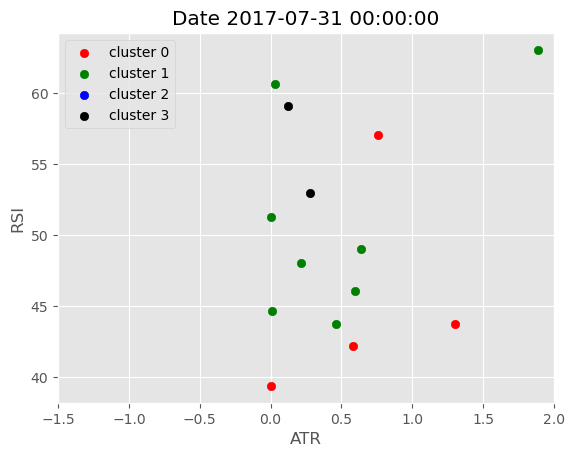

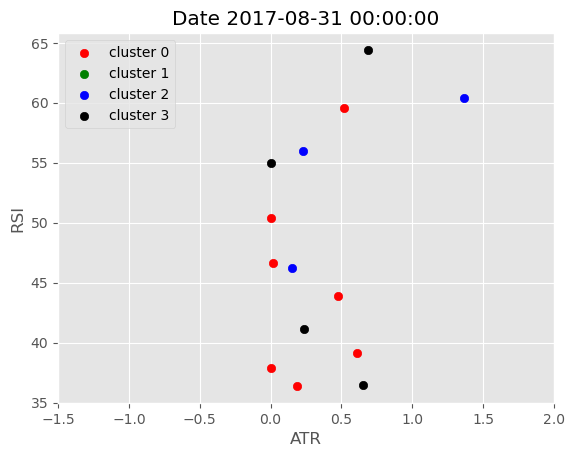

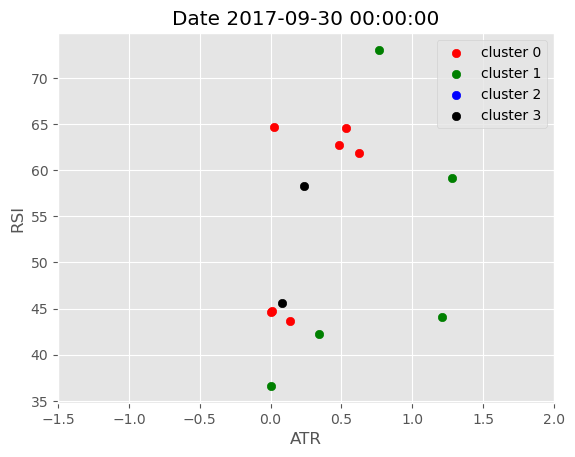

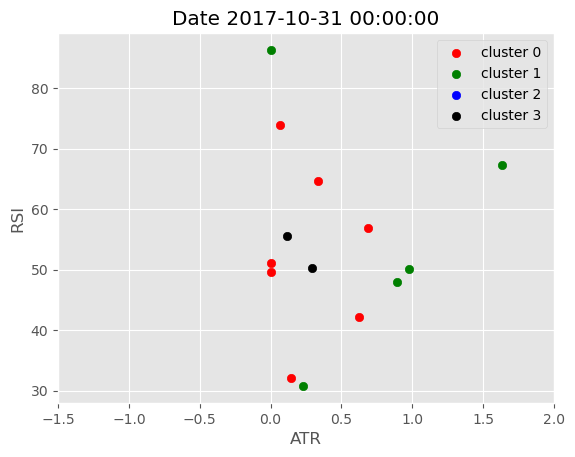

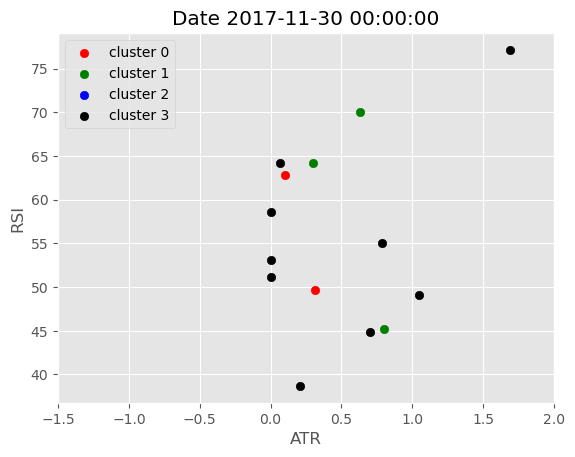

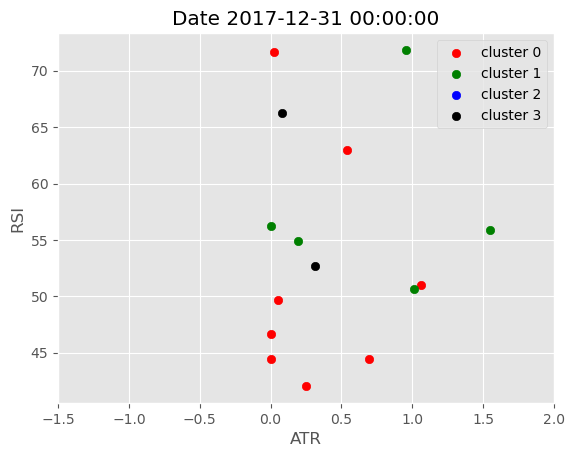

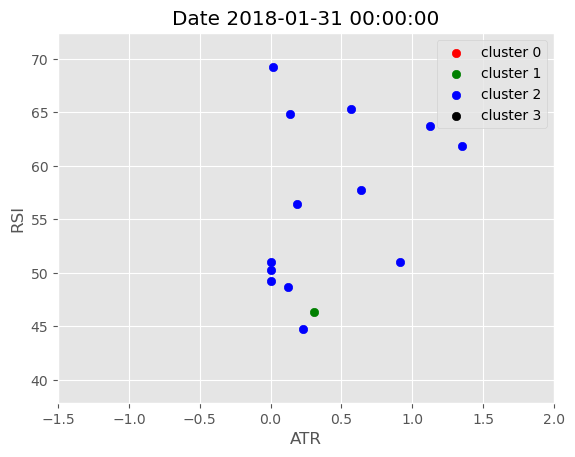

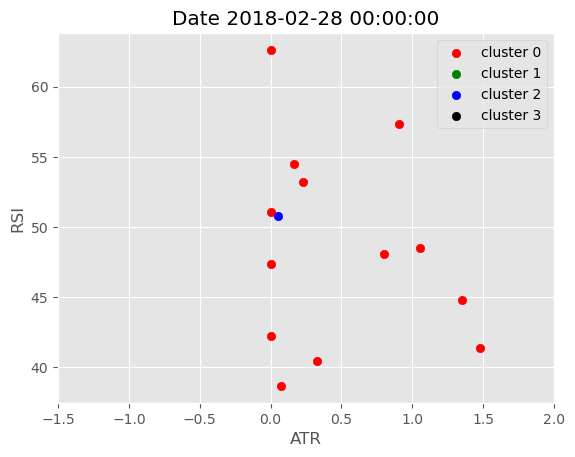

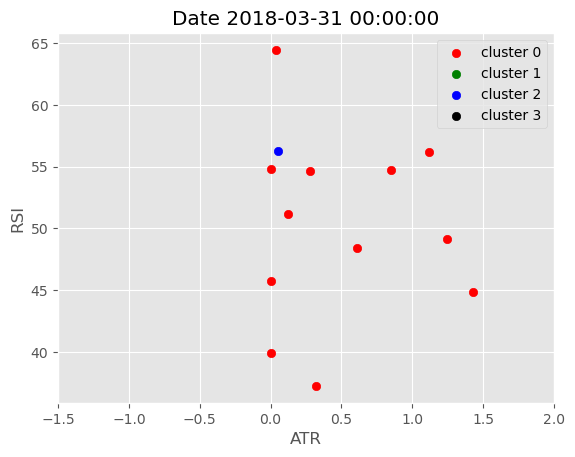

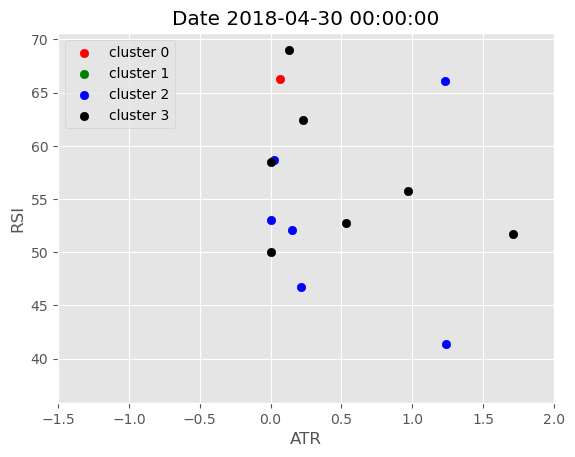

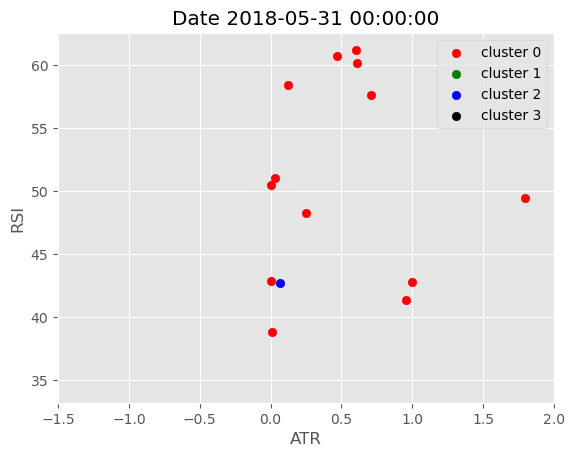

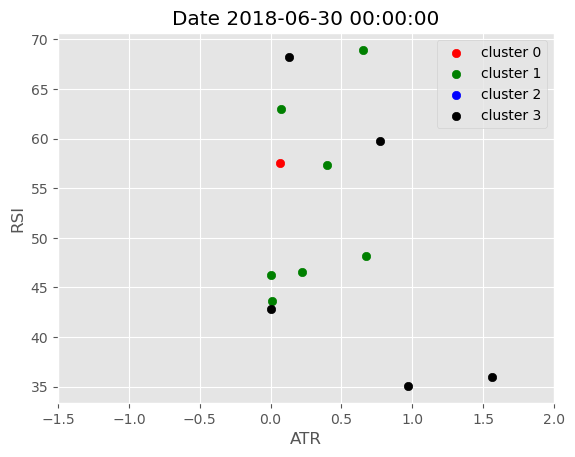

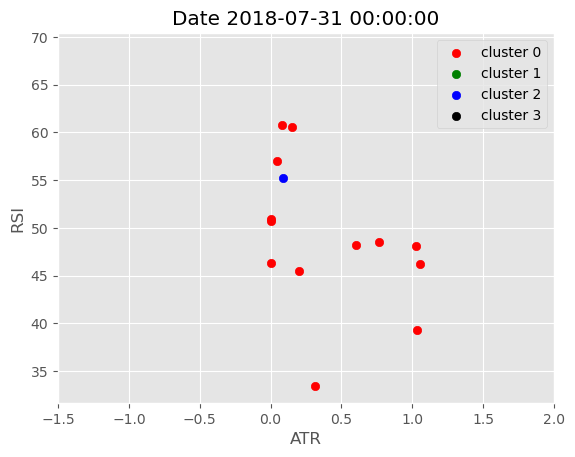

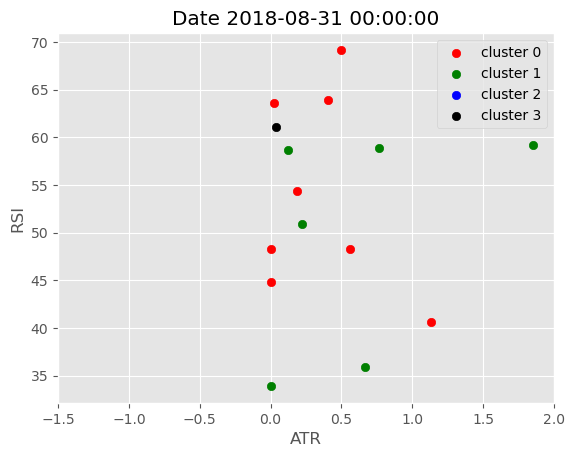

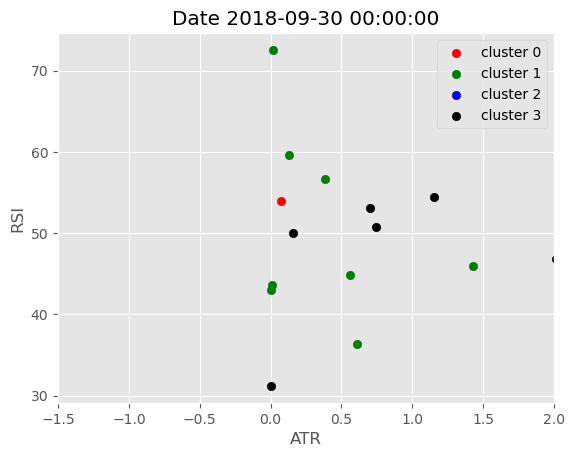

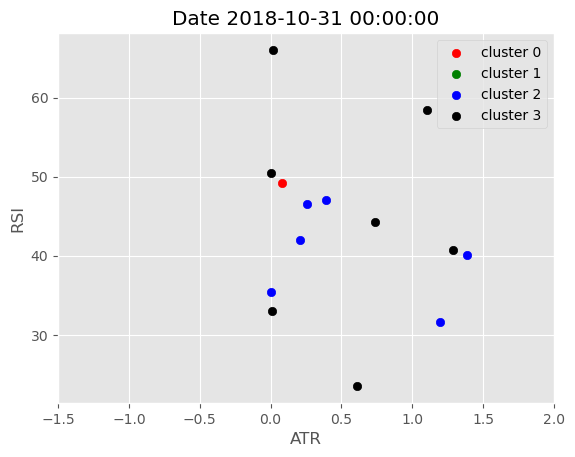

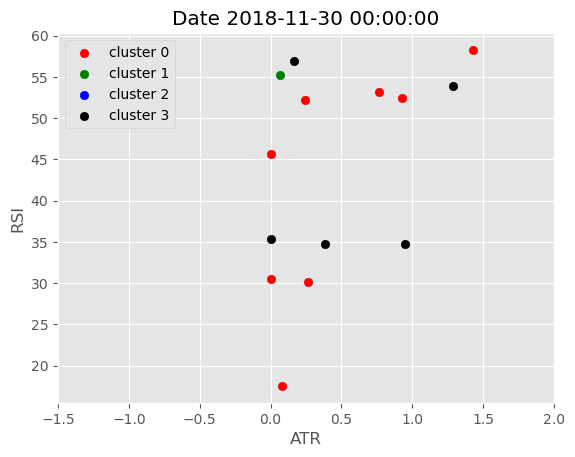

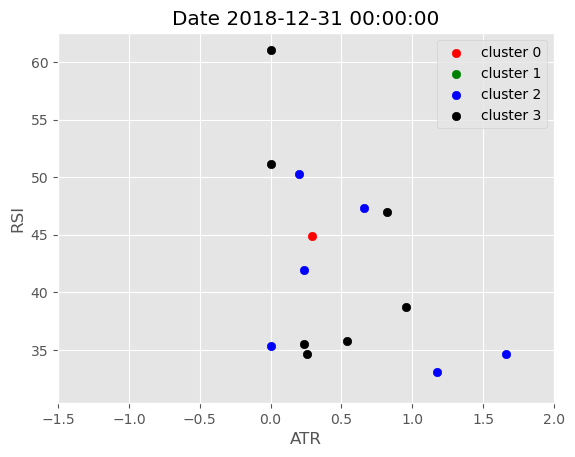

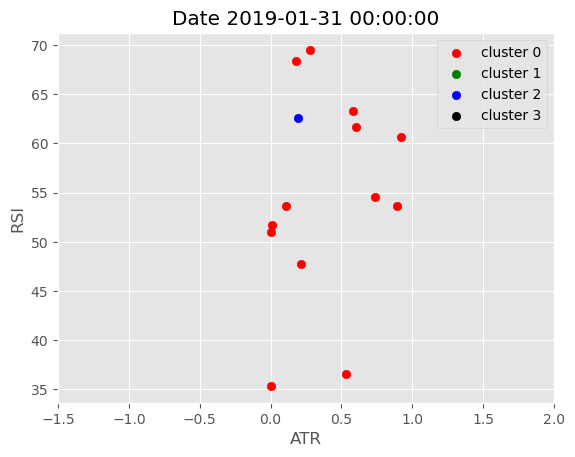

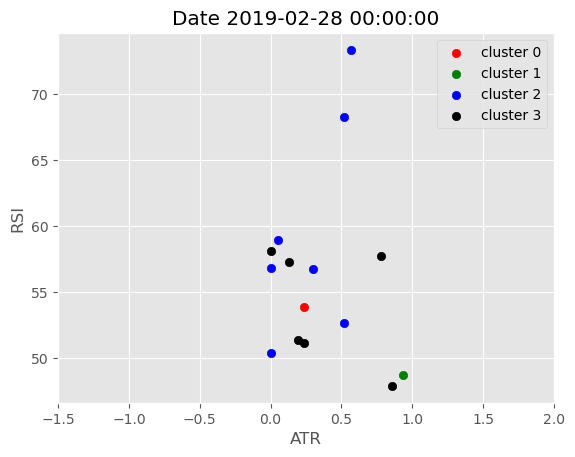

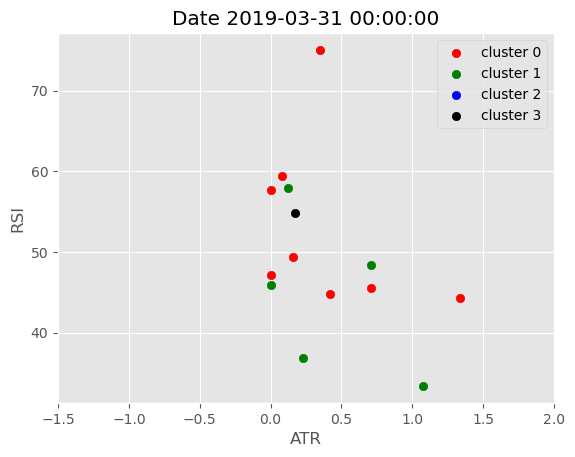

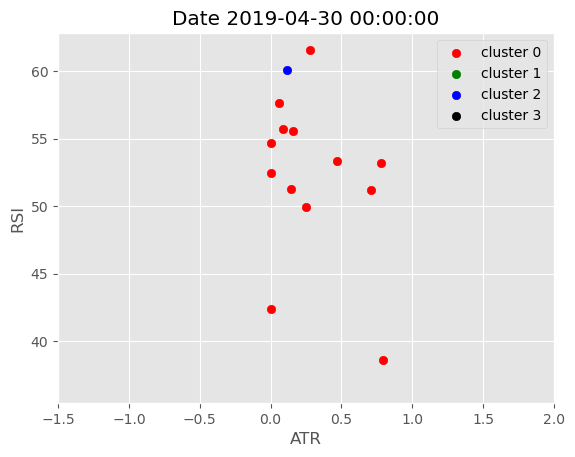

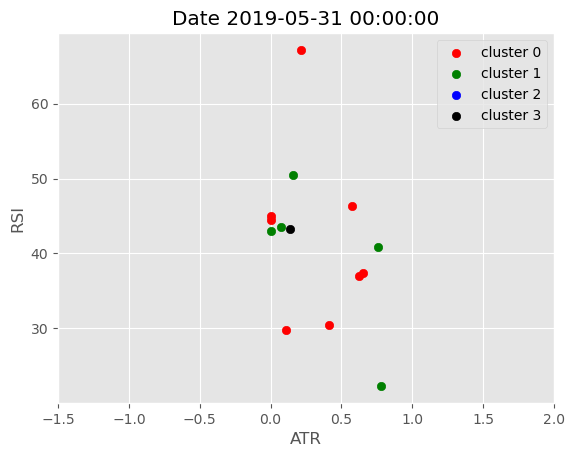

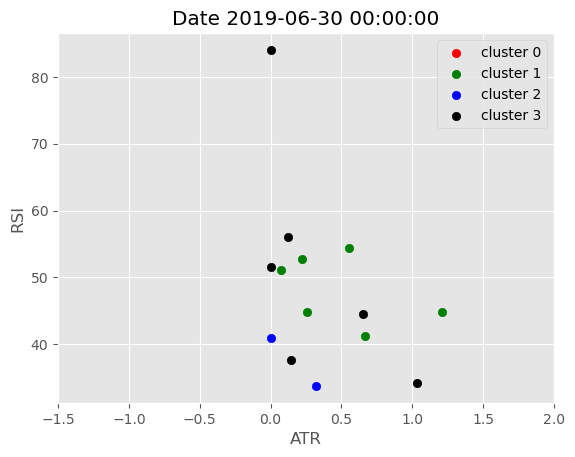

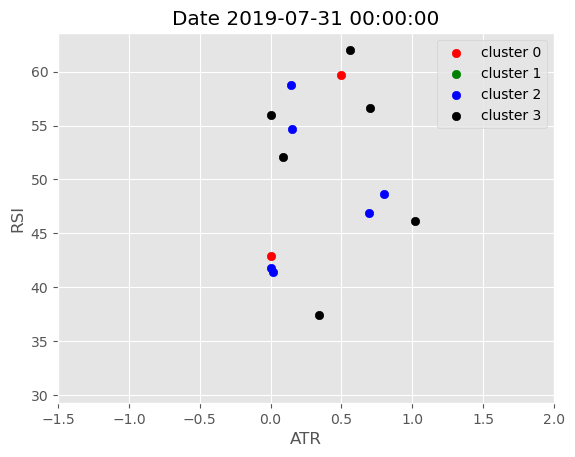

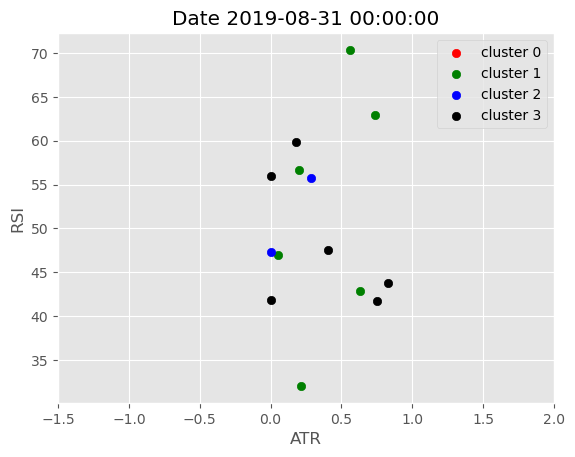

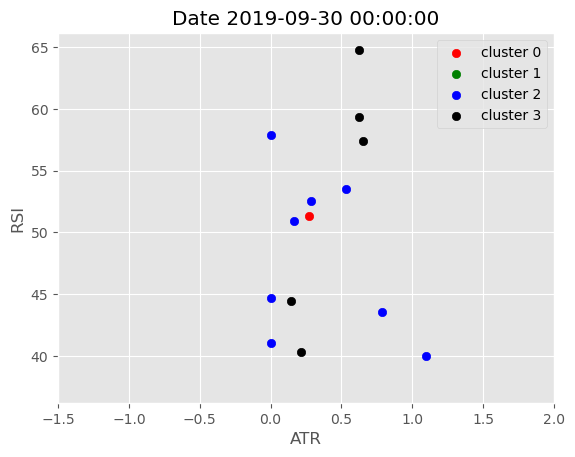

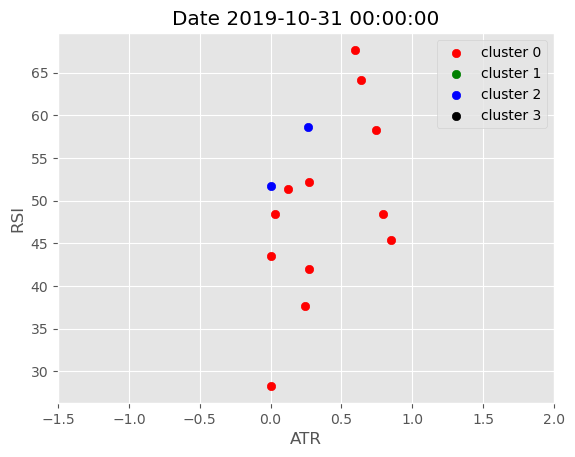

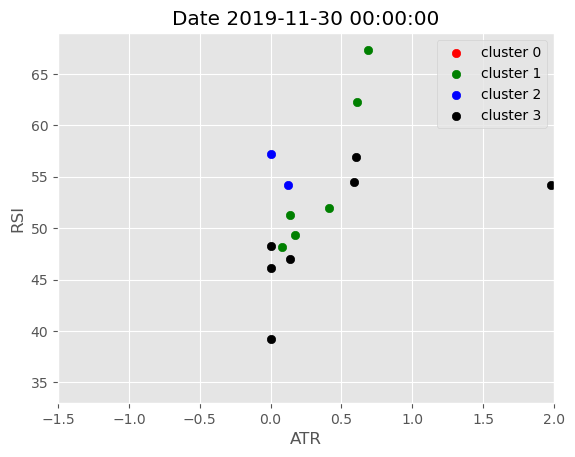

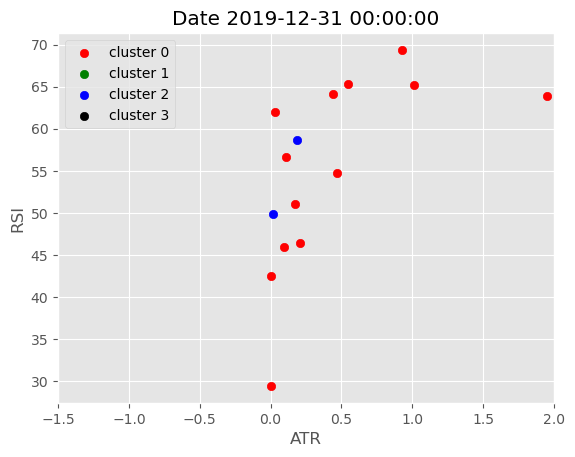

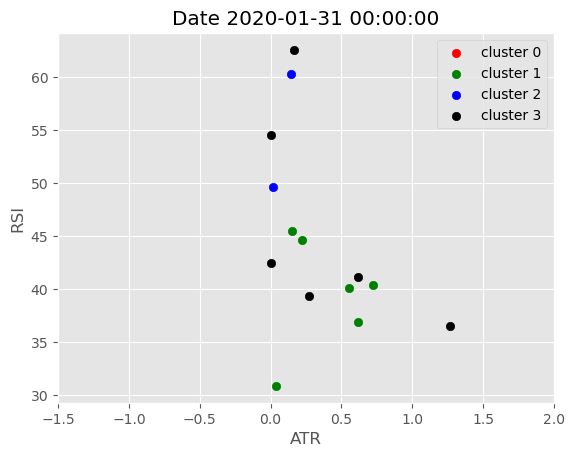

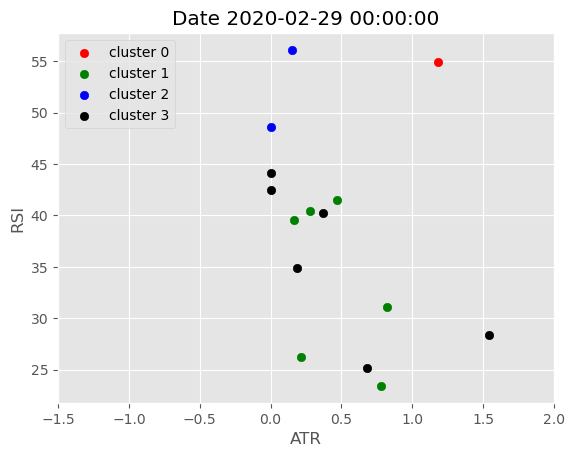

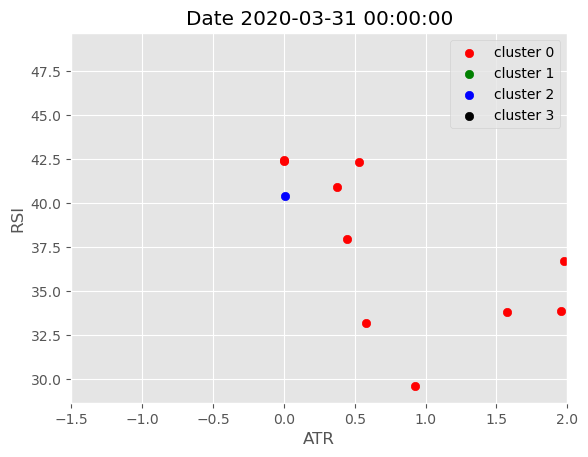

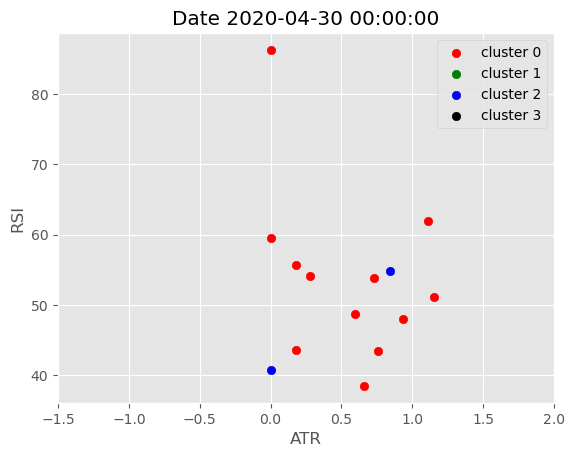

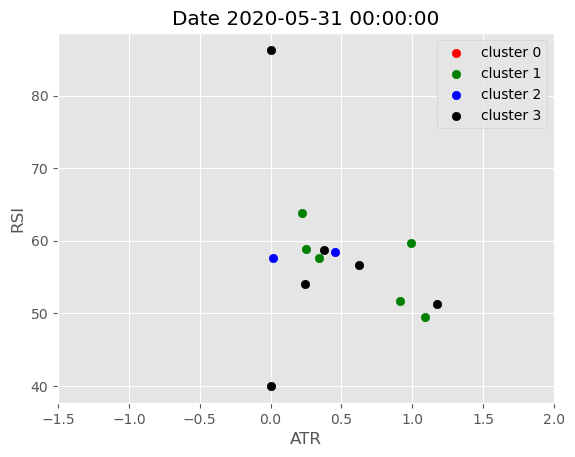

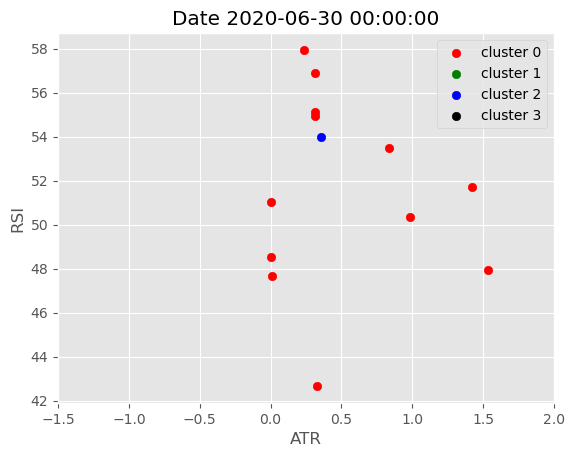

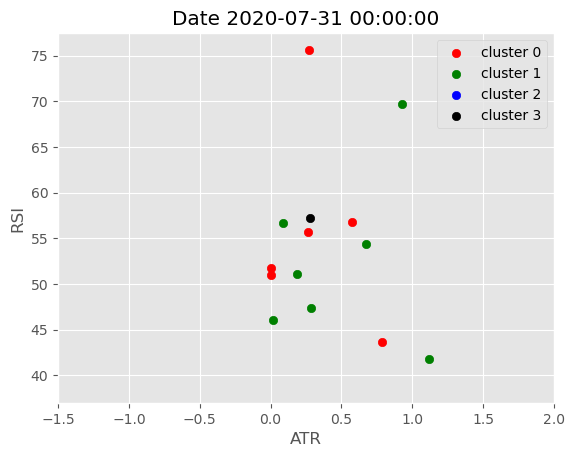

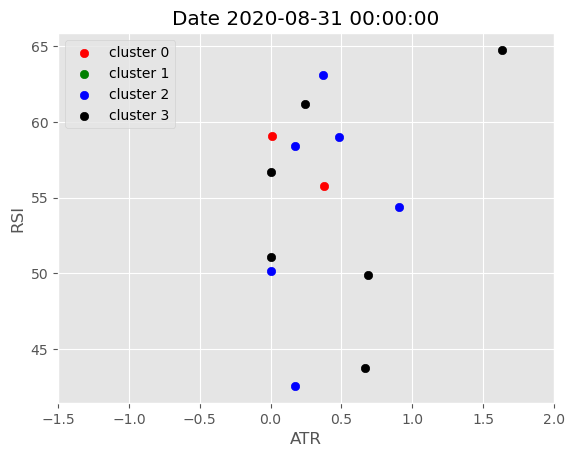

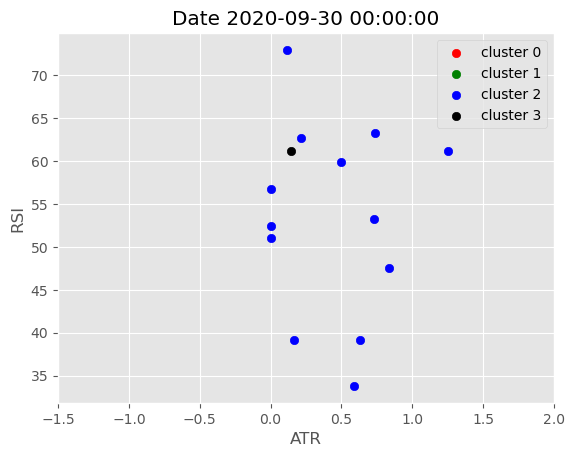

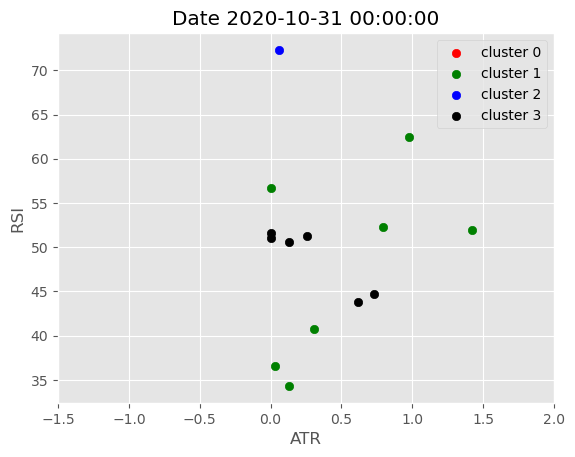

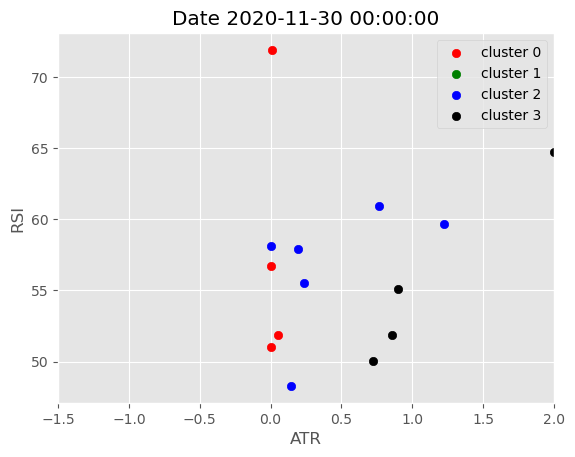

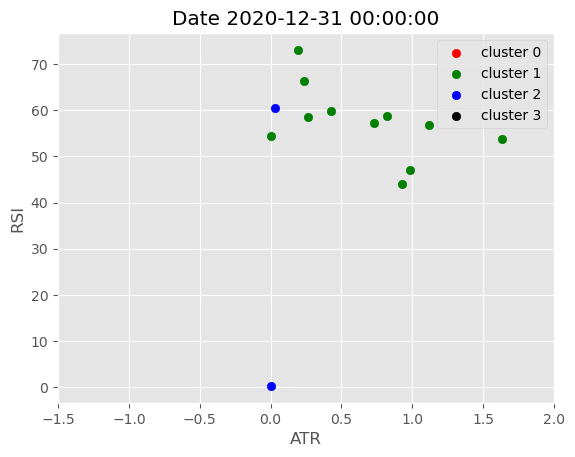

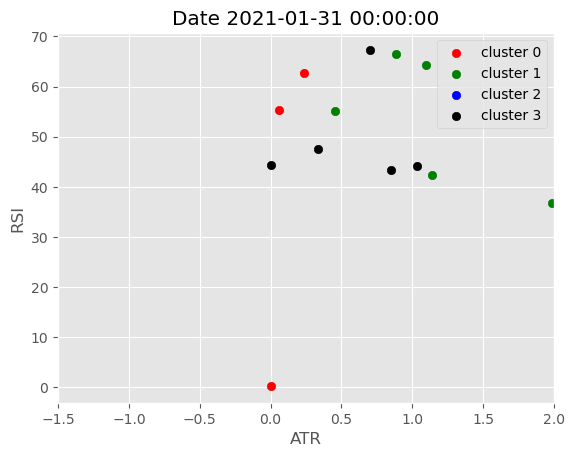

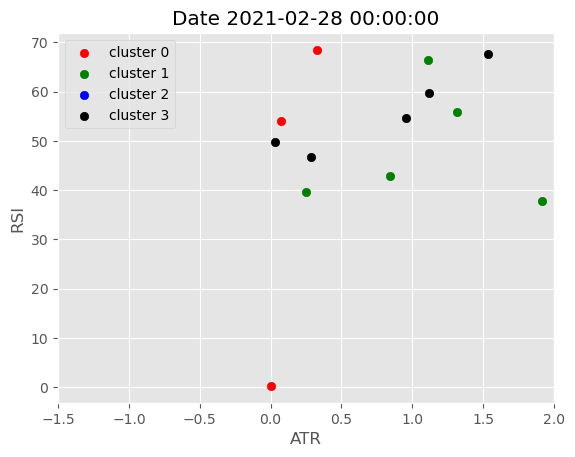

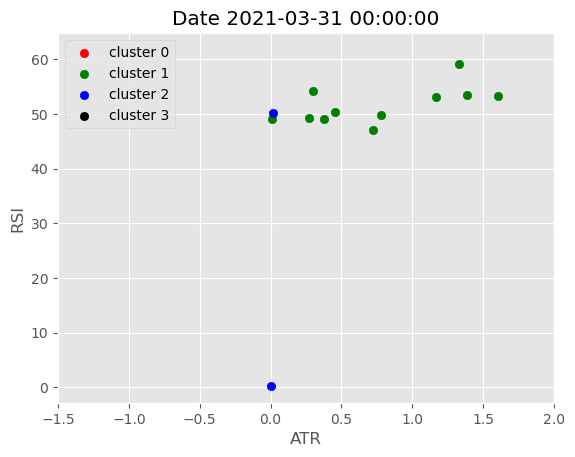

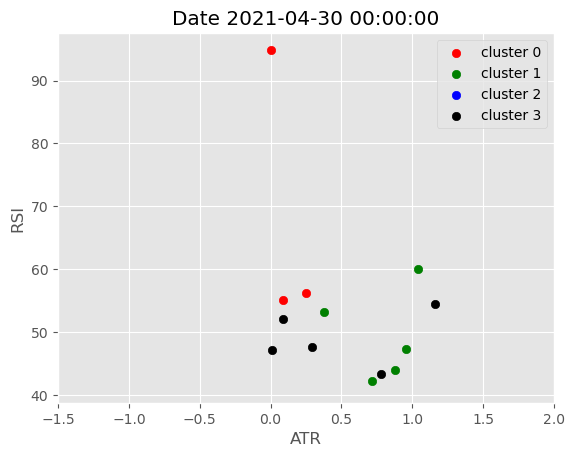

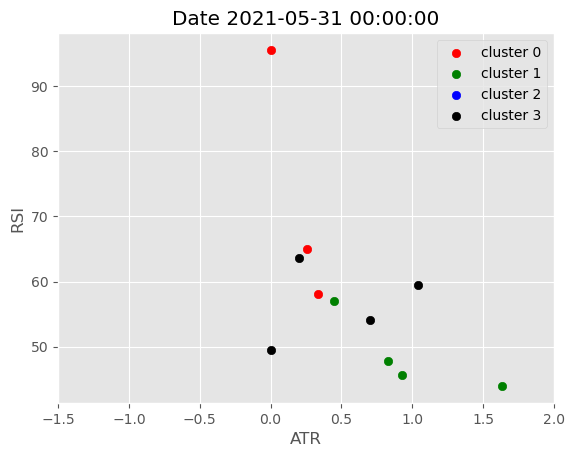

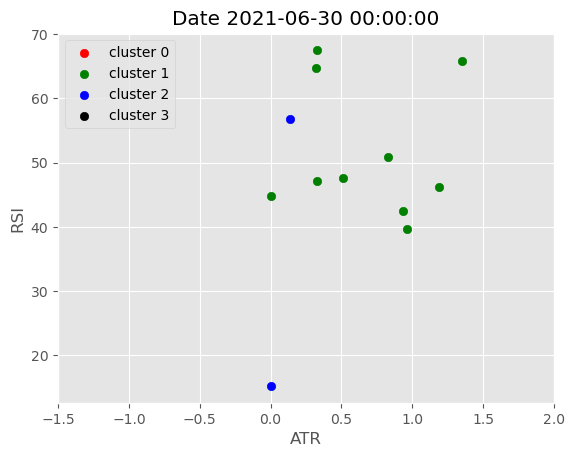

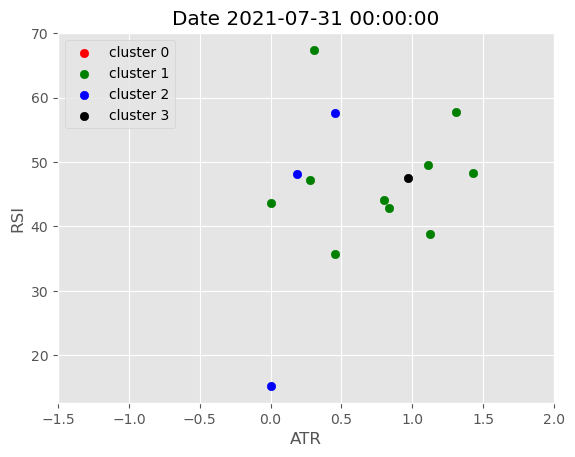

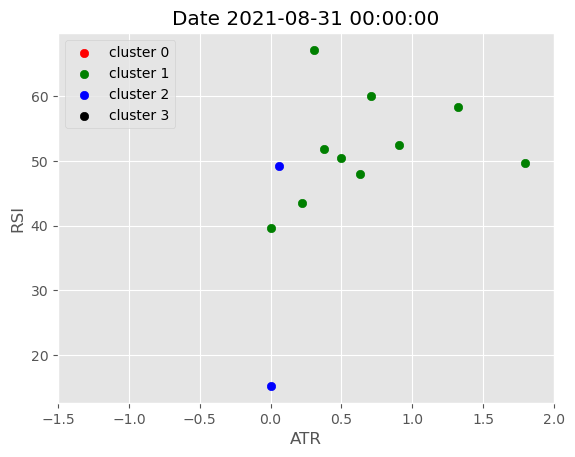

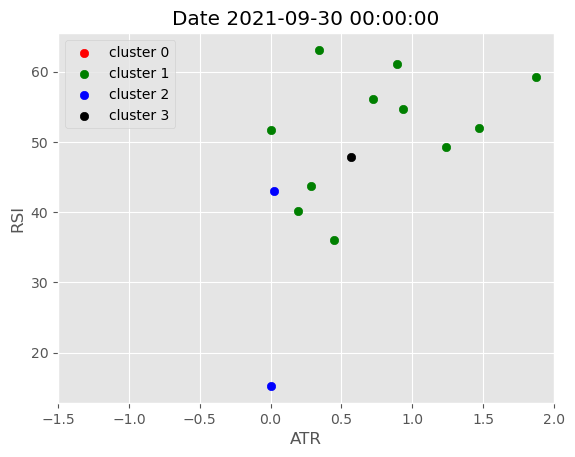

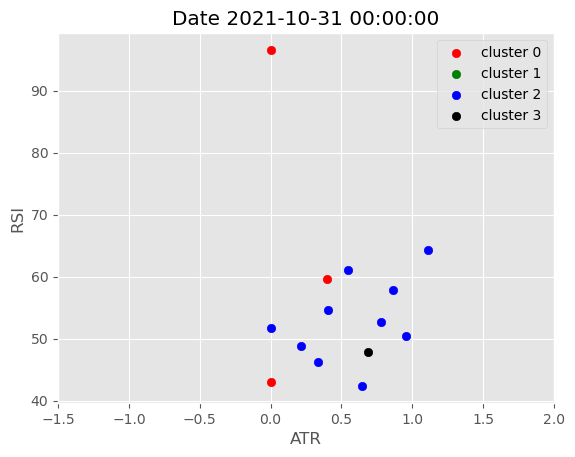

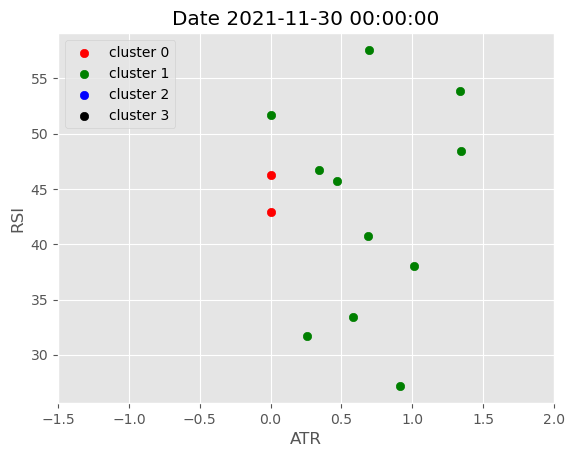

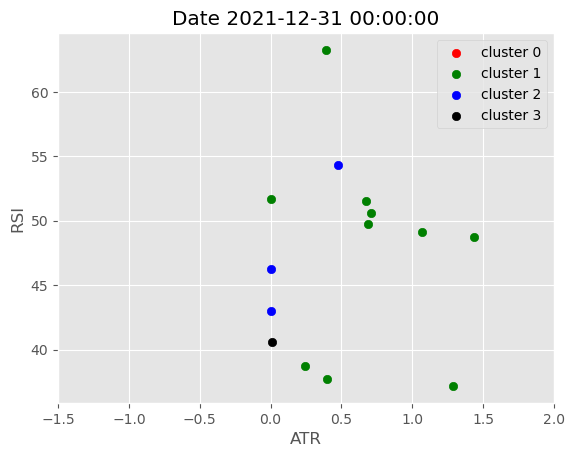

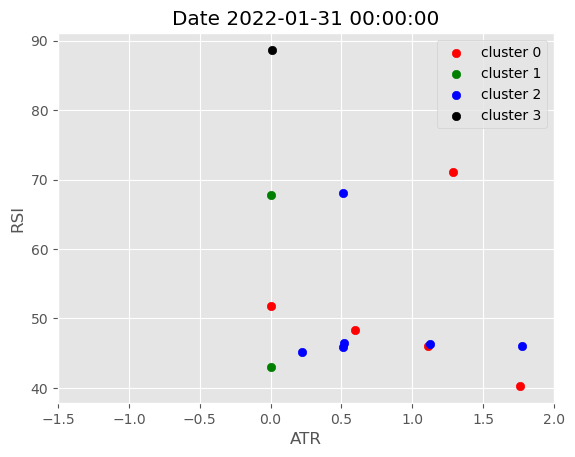

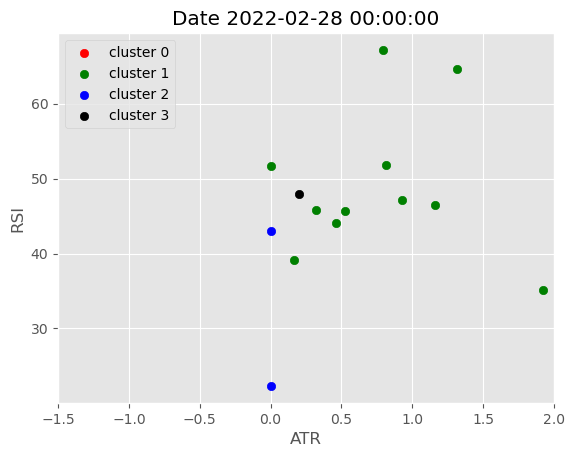

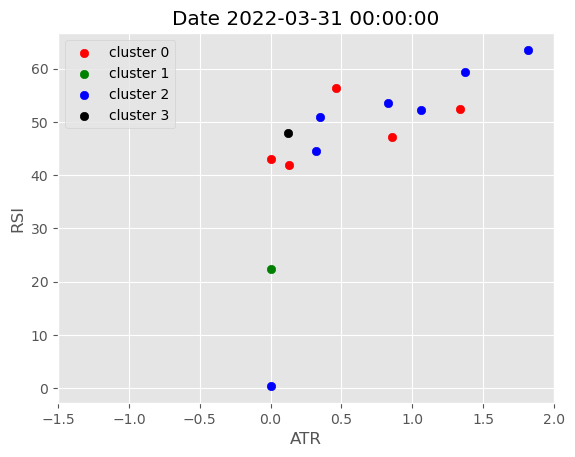

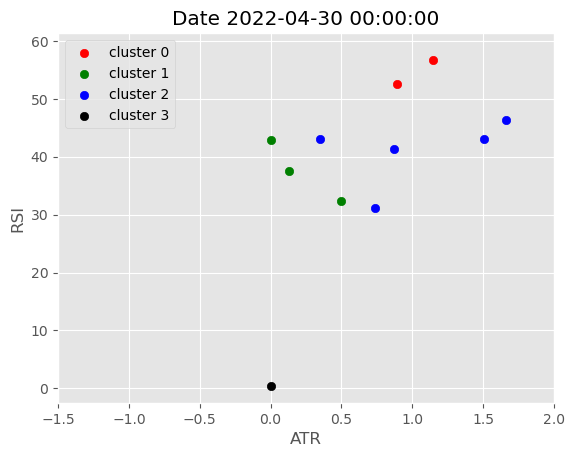

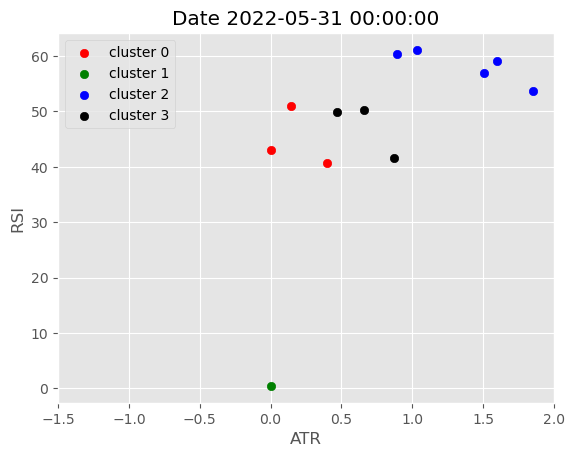

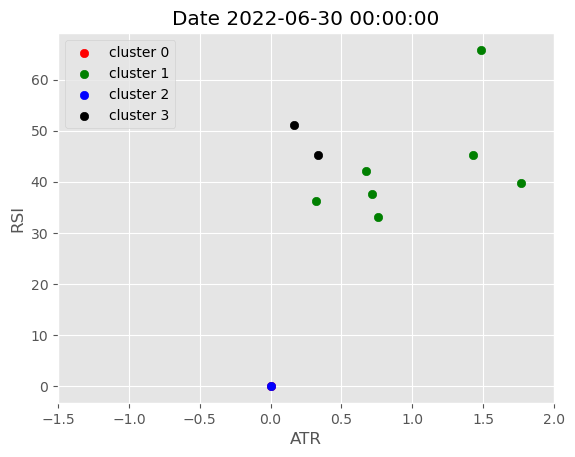

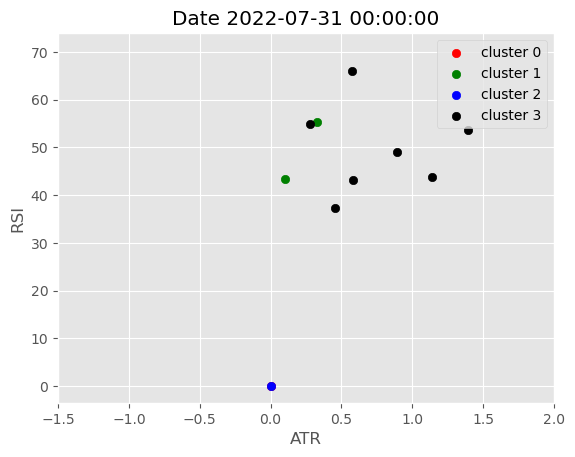

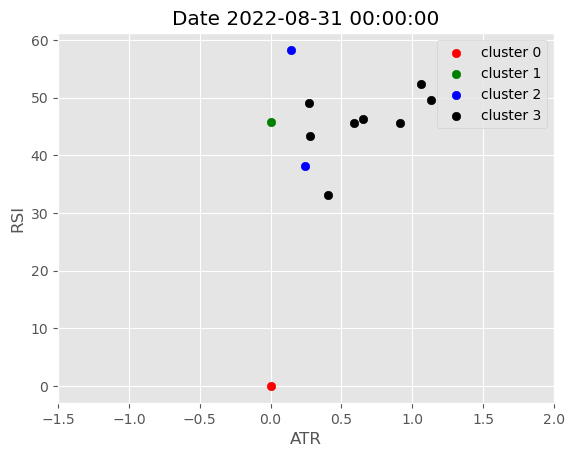

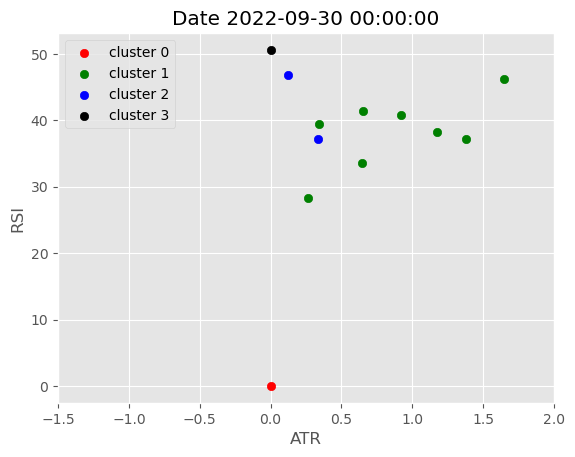

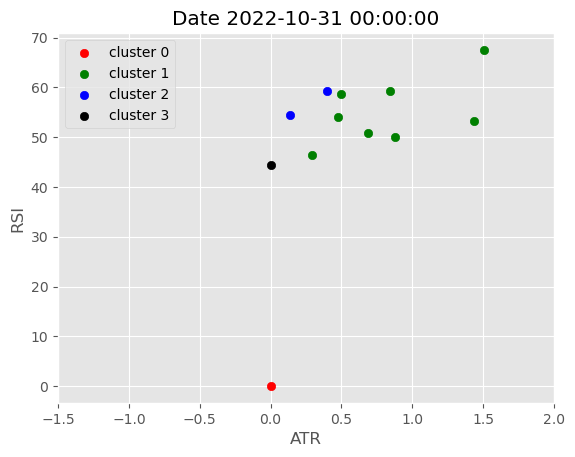

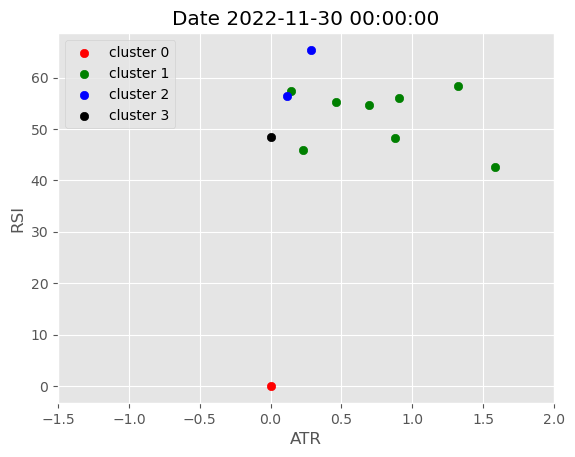

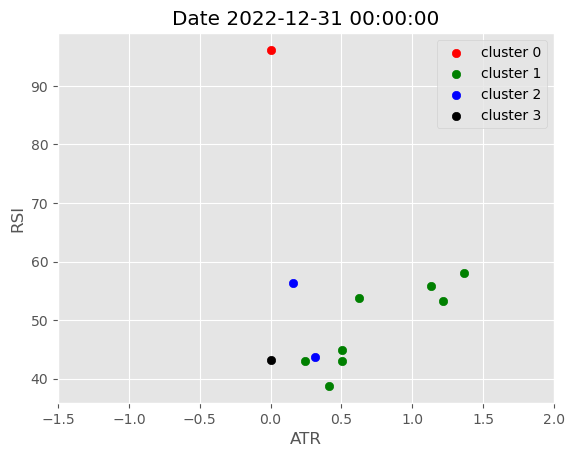

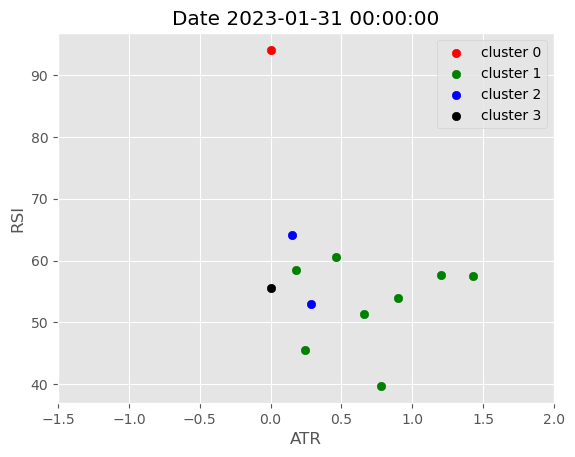

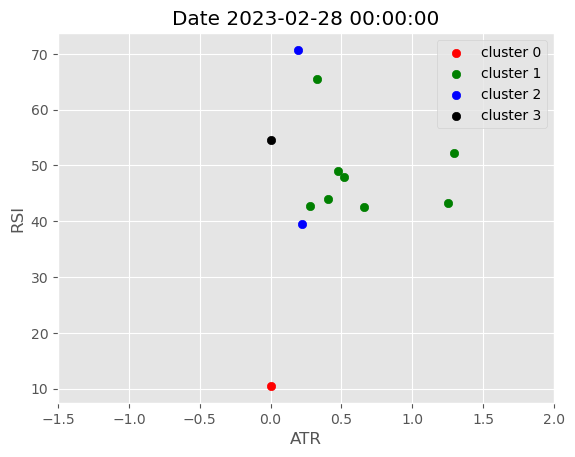

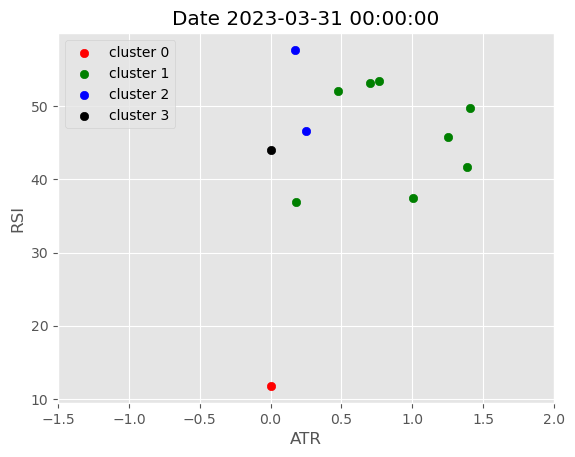

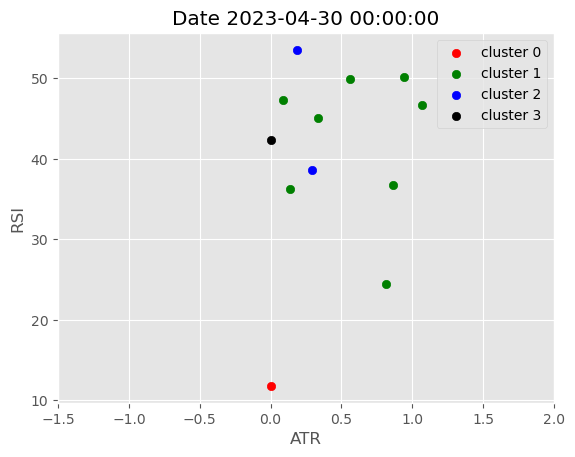

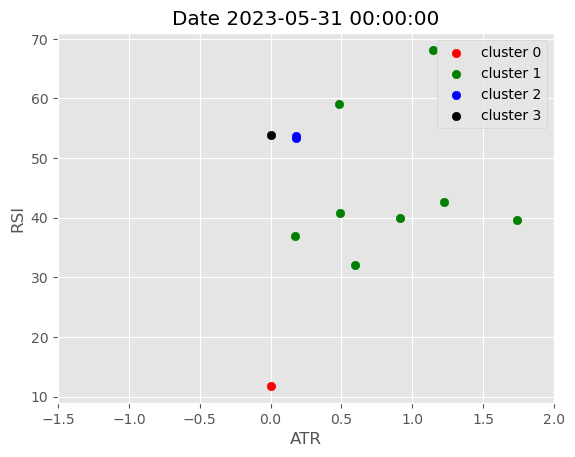

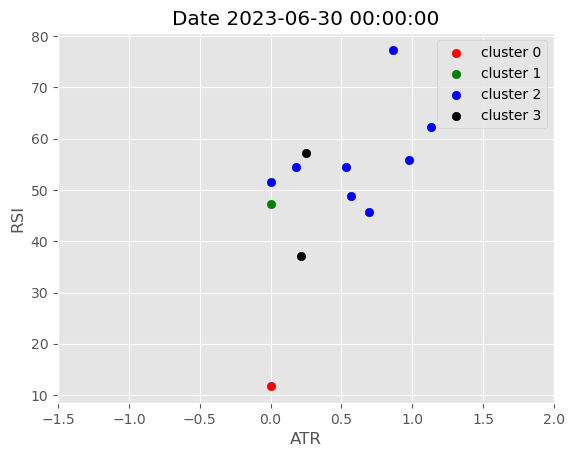

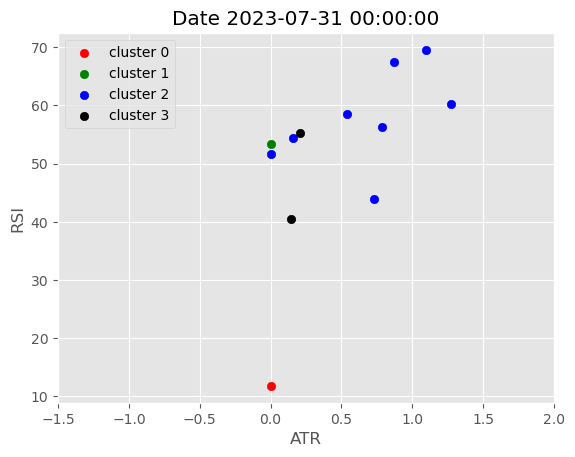

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [15]:
#Apply pre-defined centroids.

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 20))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

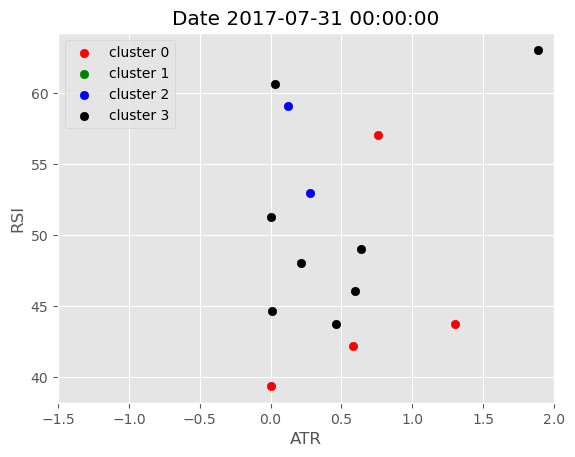

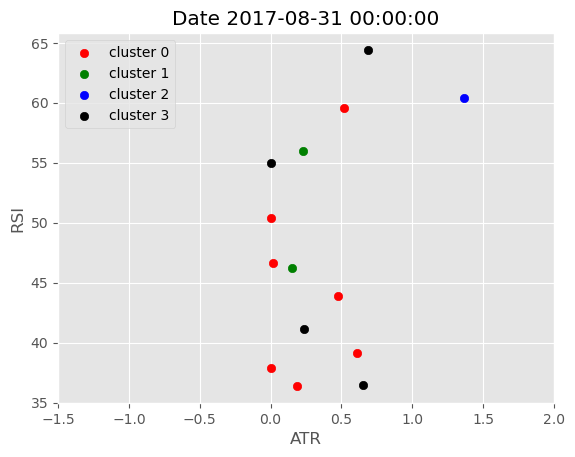

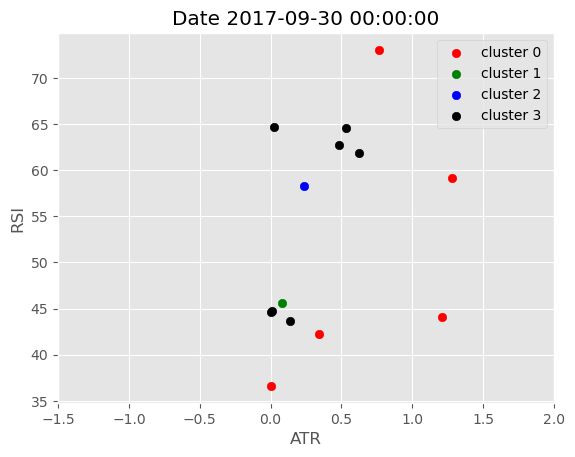

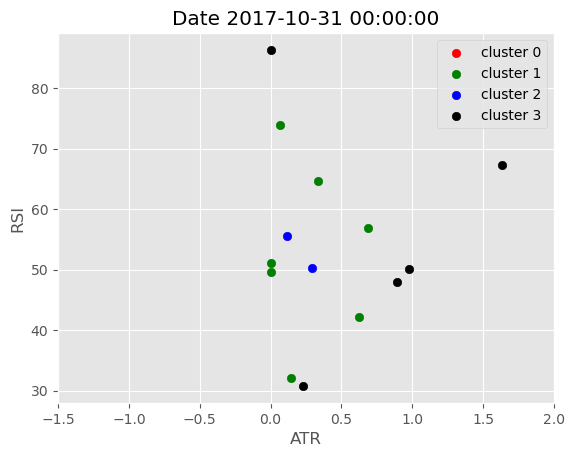

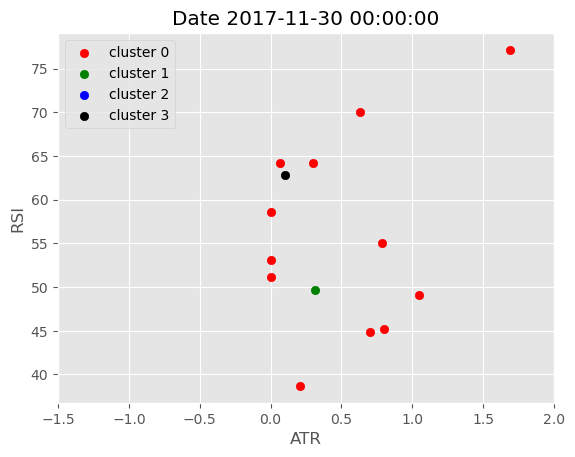

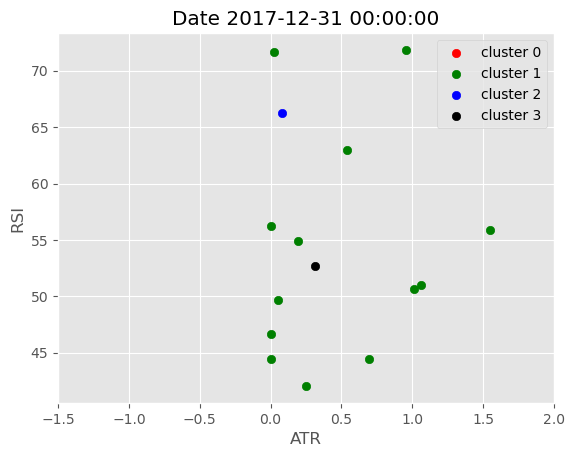

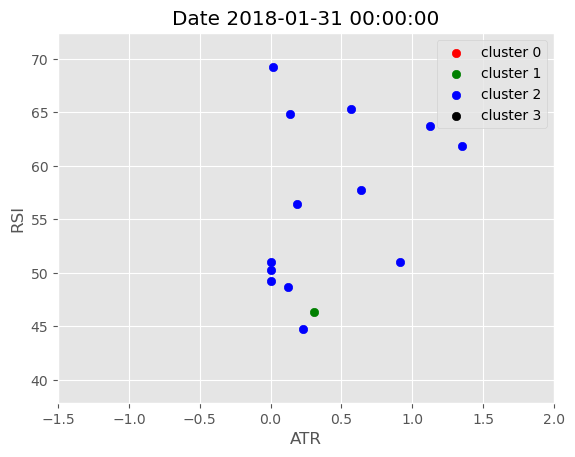

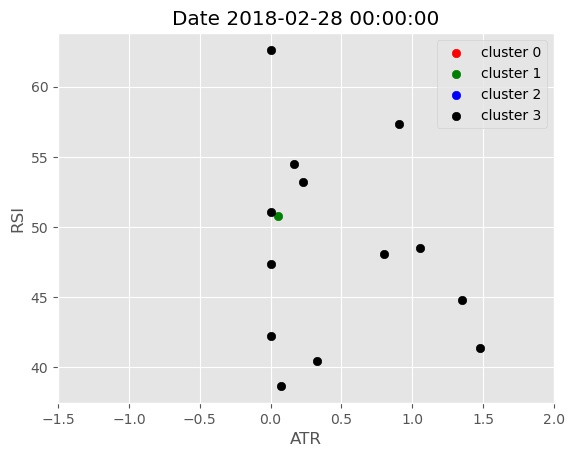

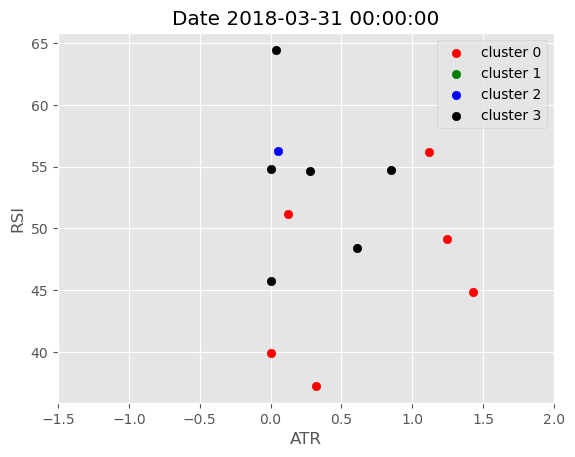

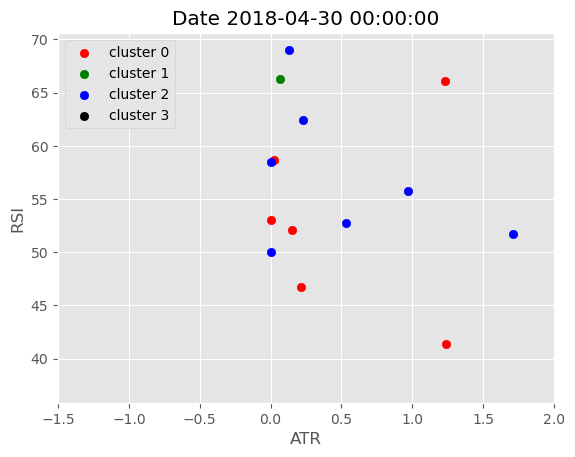

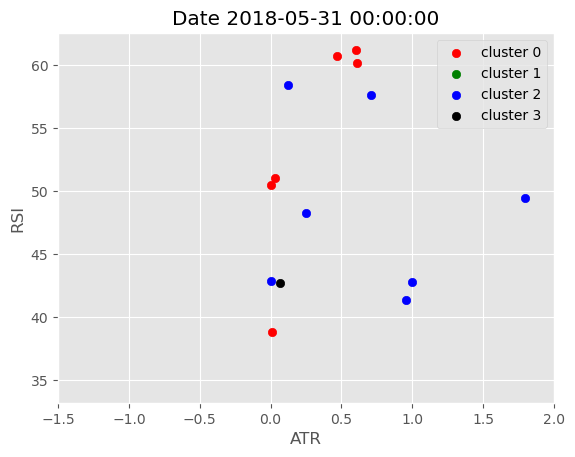

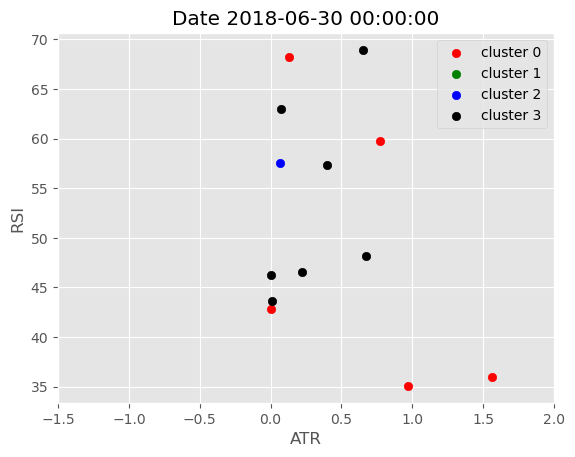

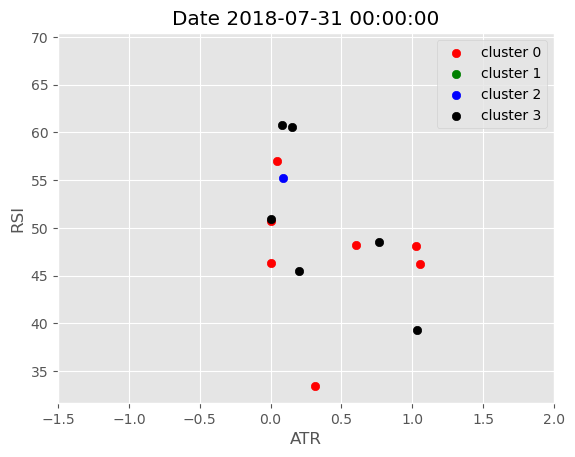

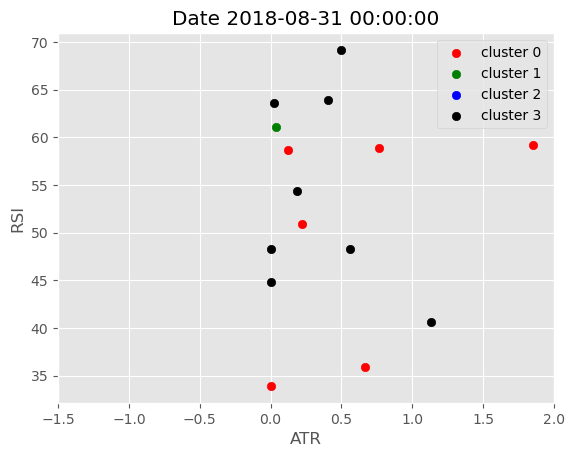

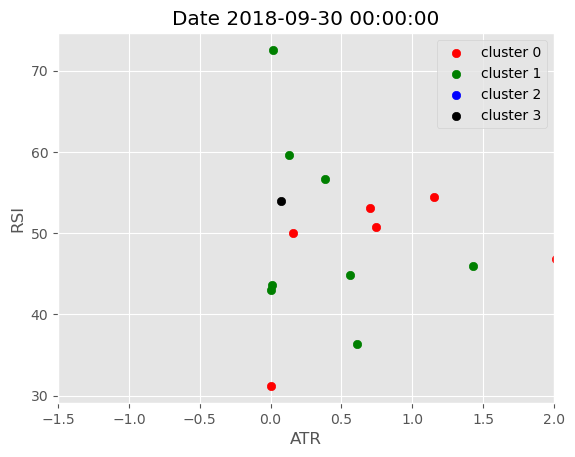

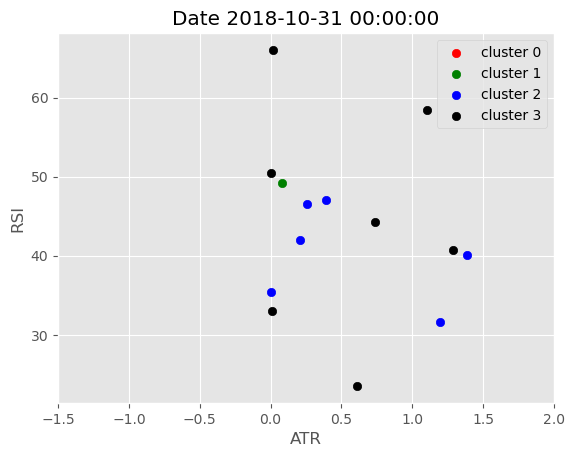

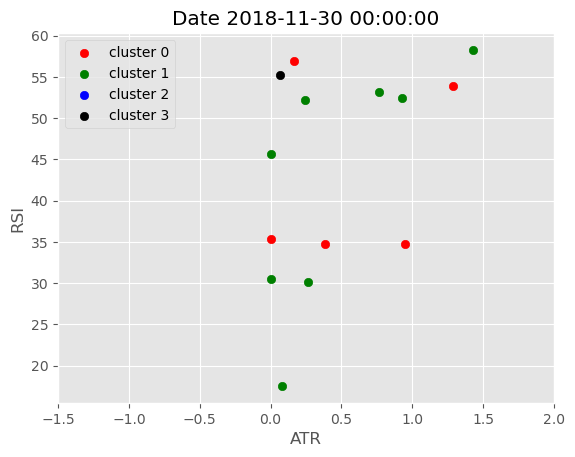

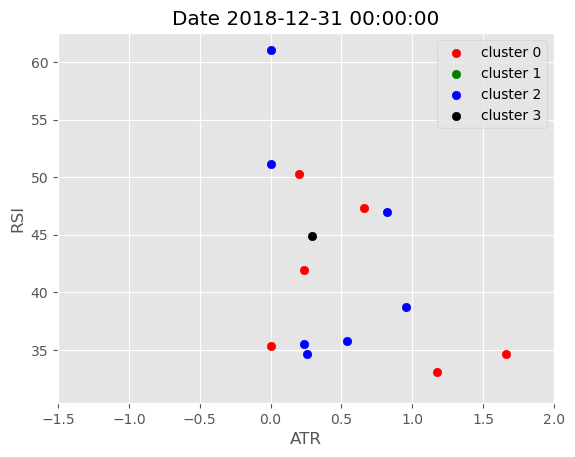

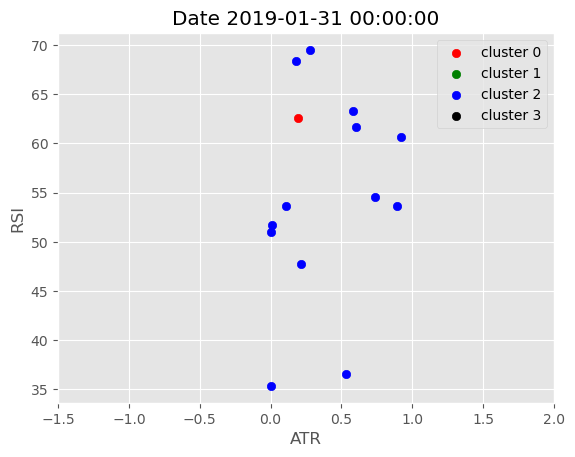

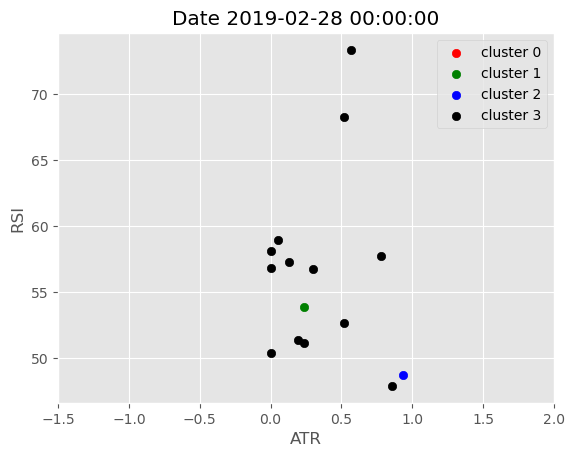

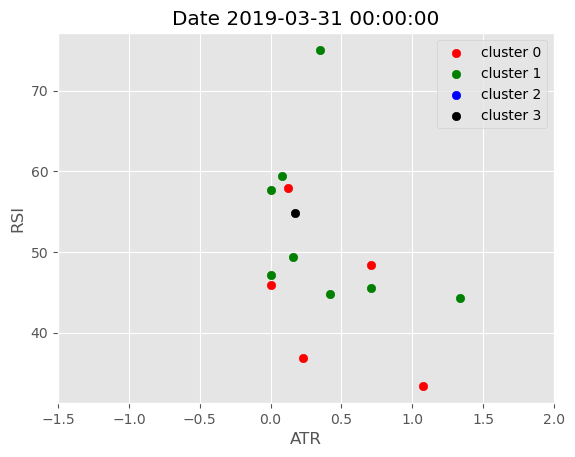

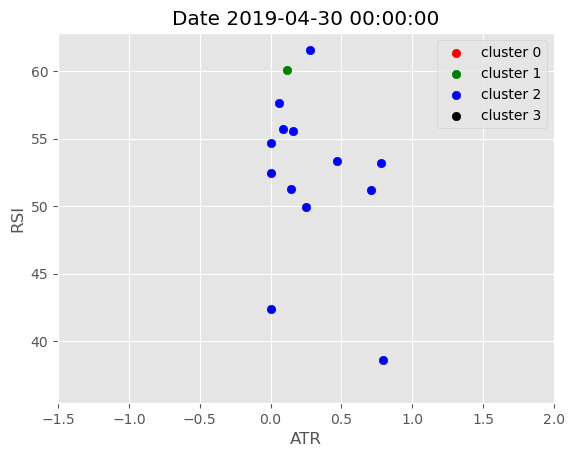

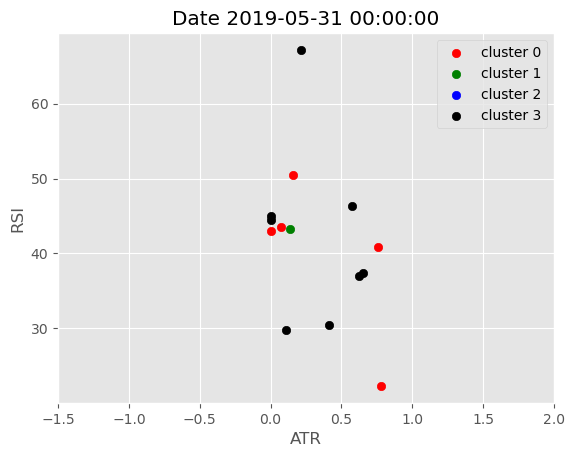

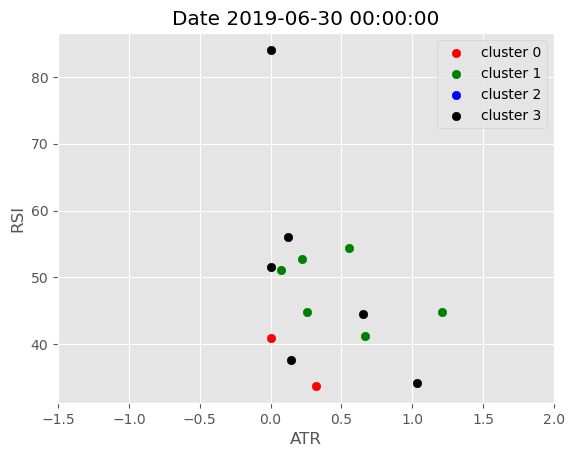

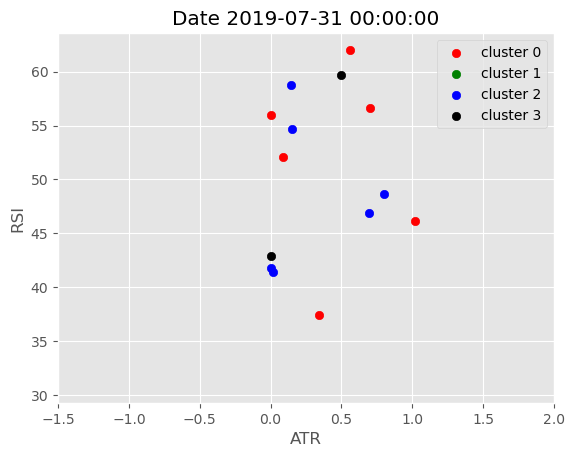

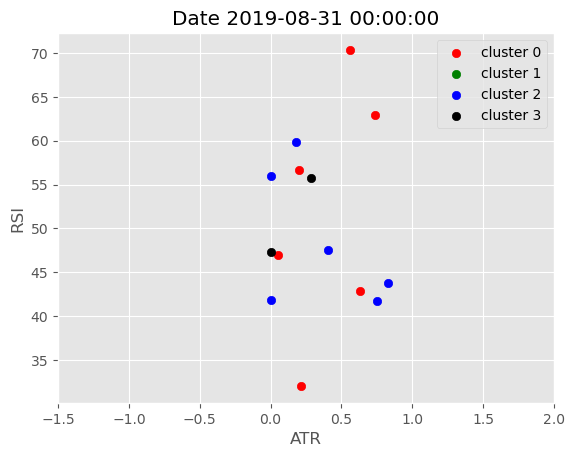

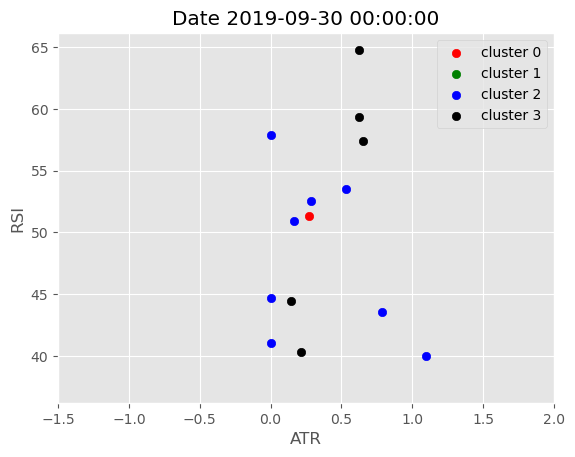

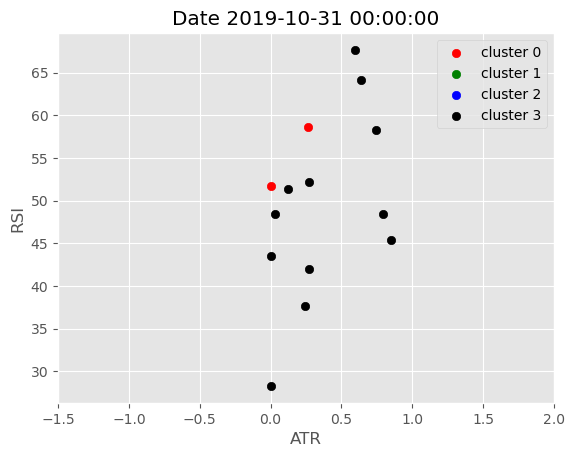

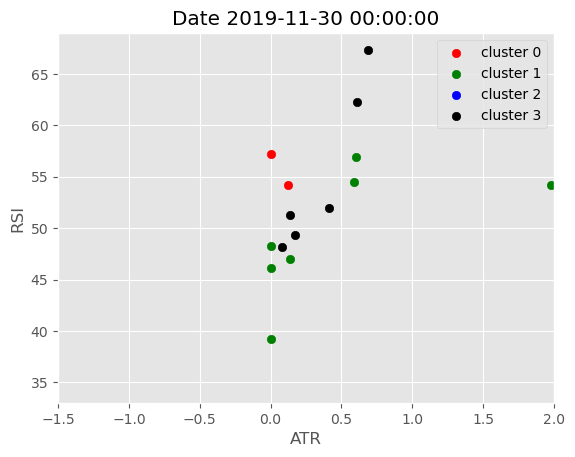

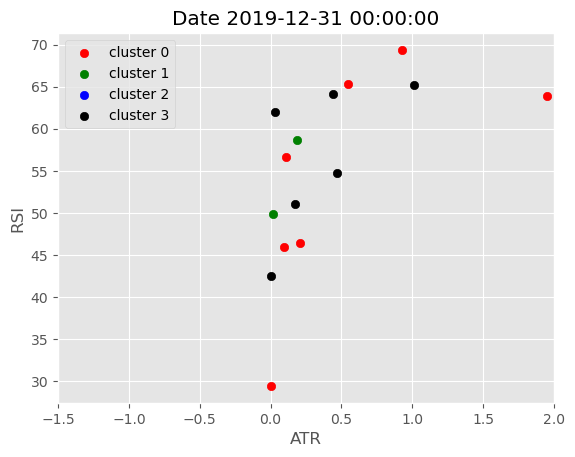

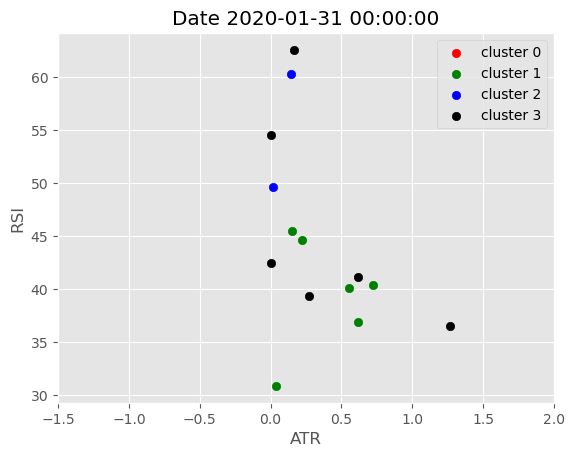

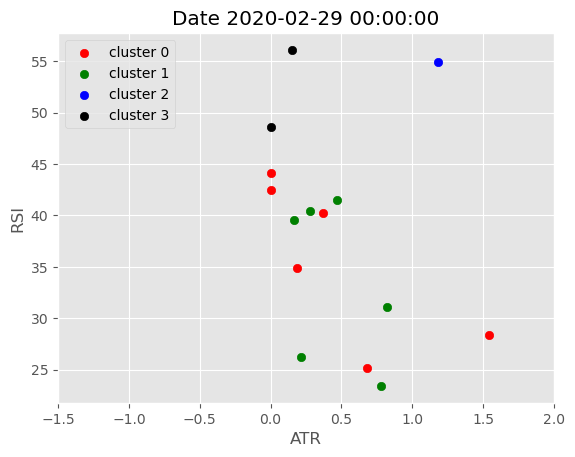

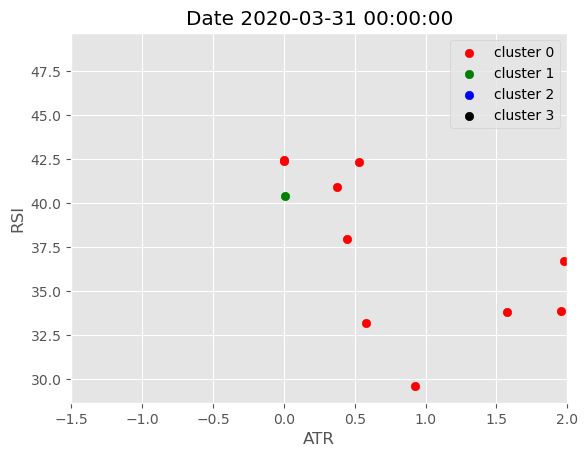

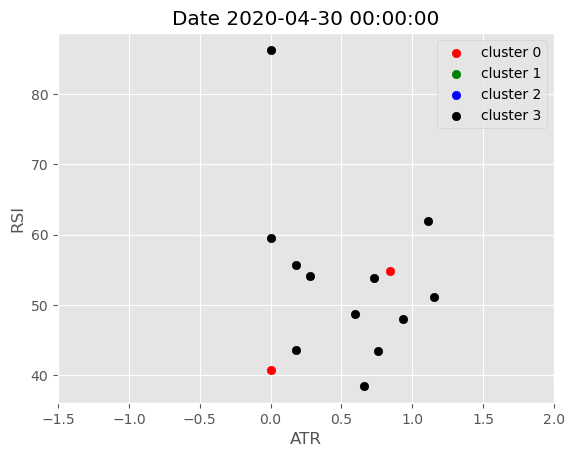

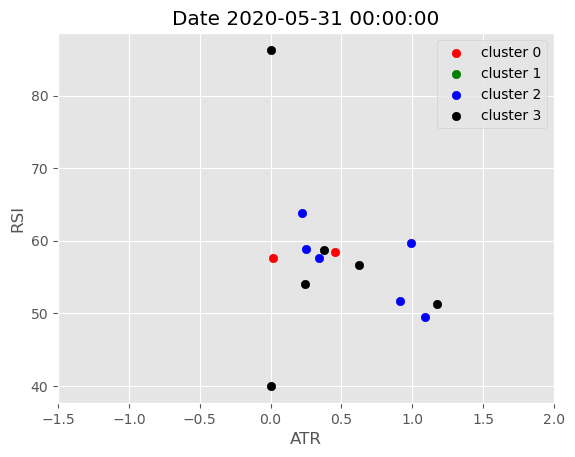

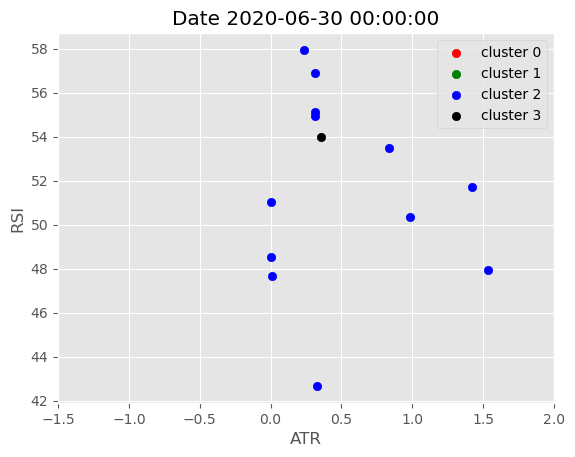

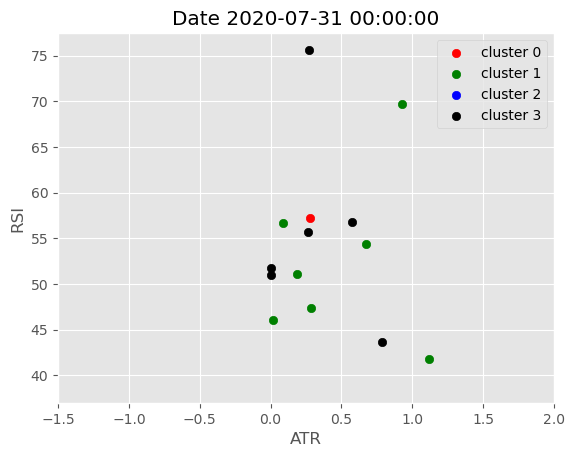

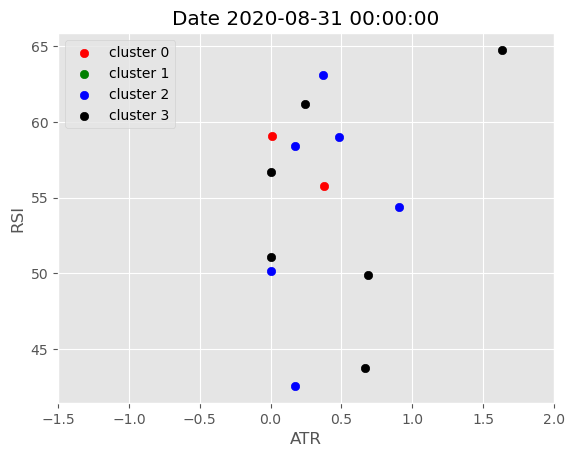

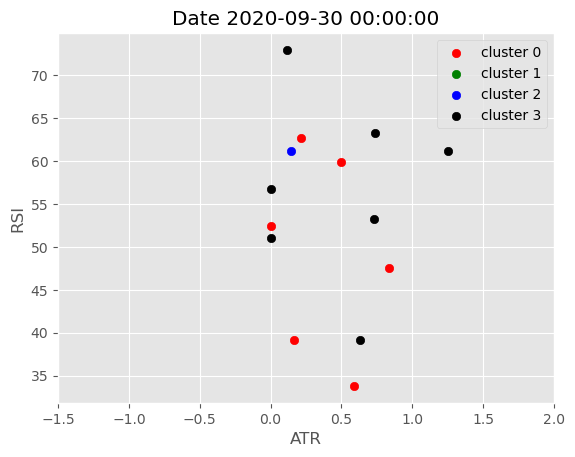

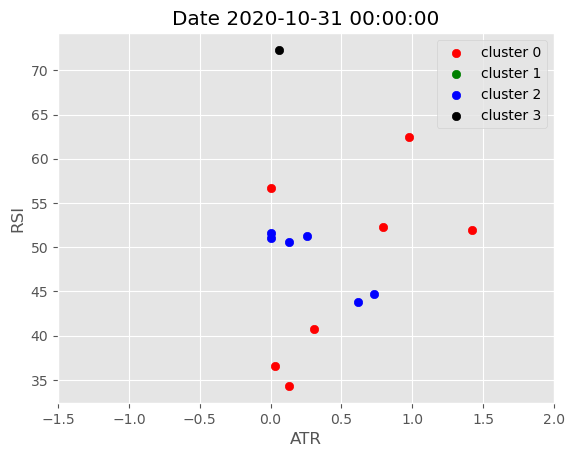

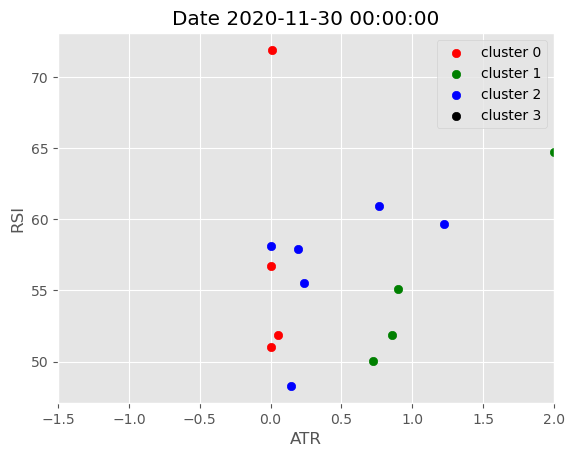

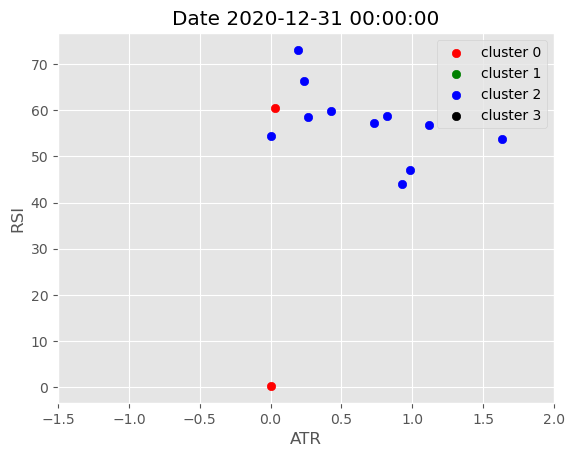

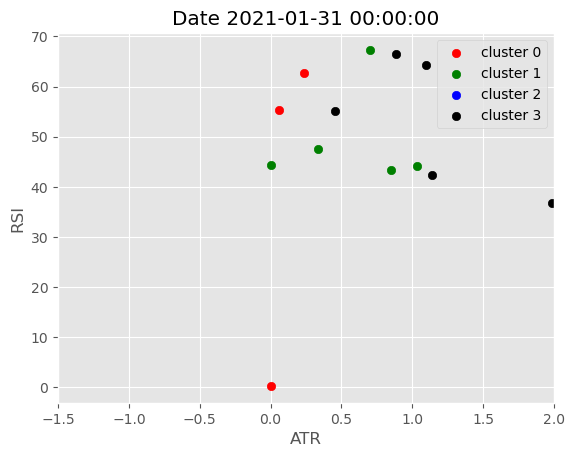

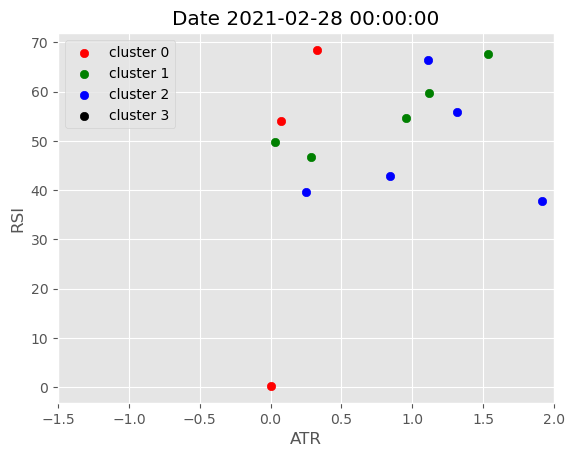

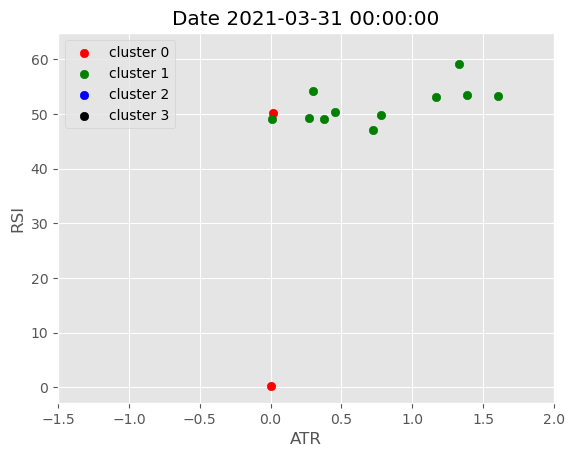

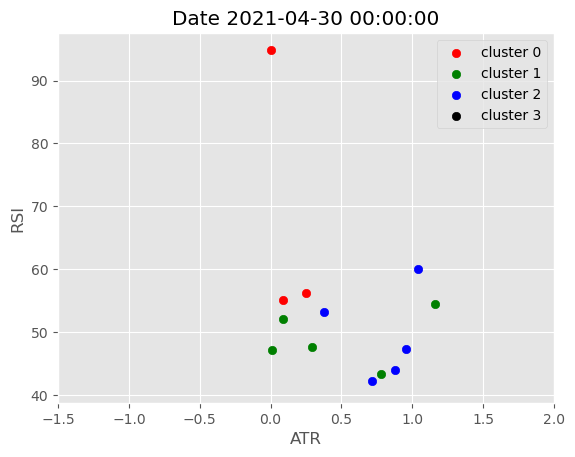

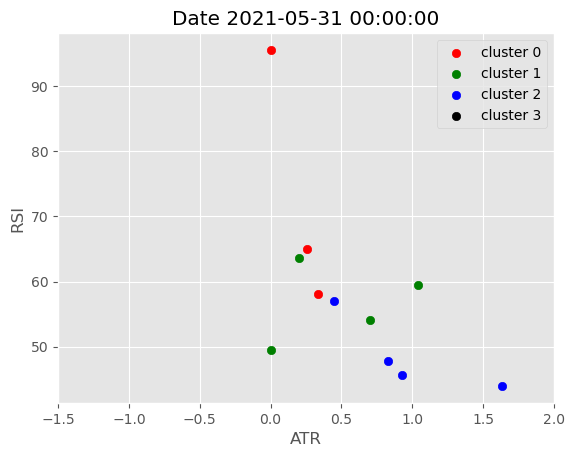

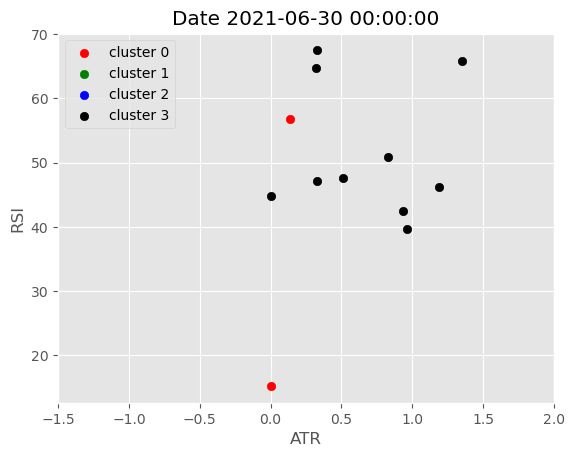

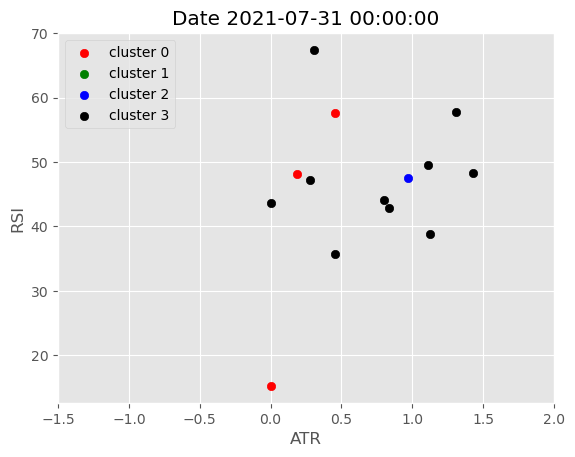

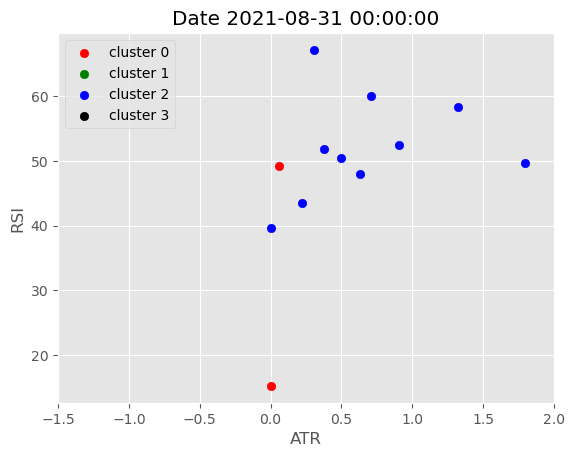

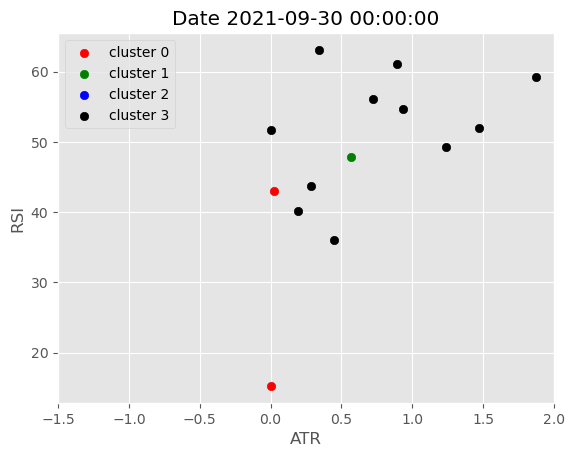

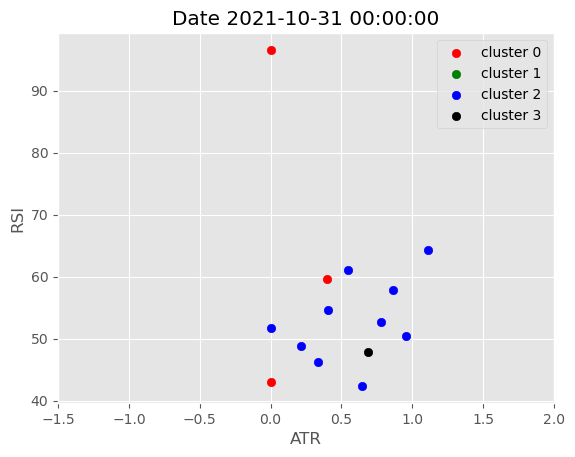

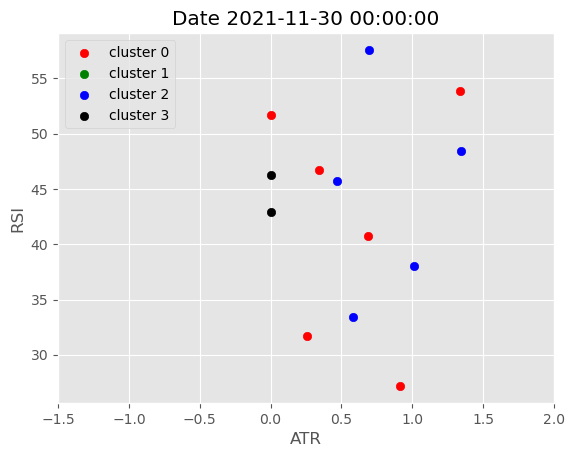

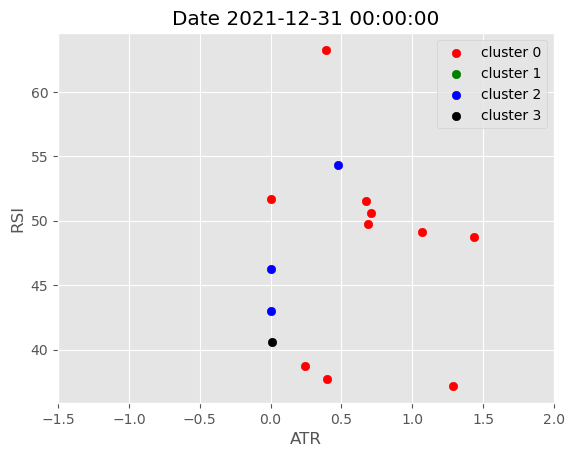

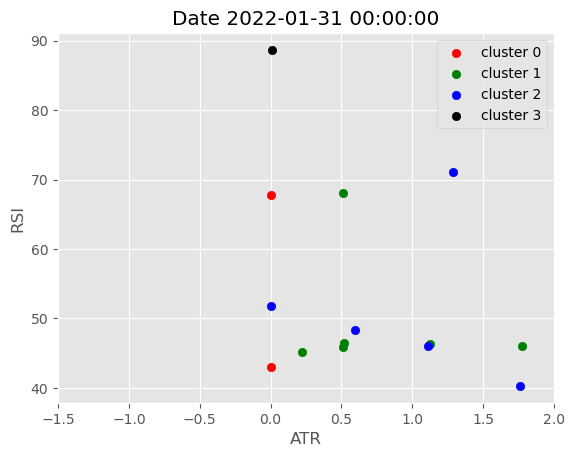

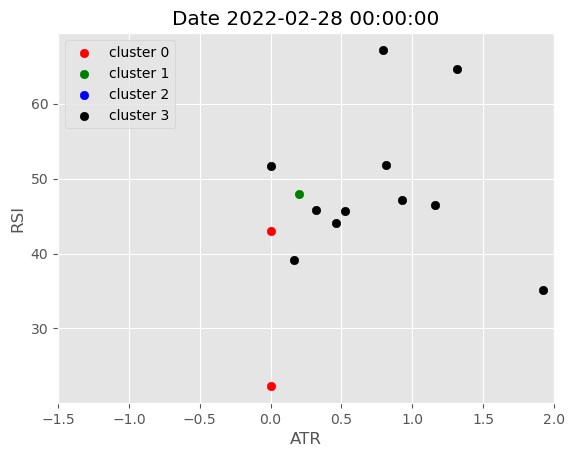

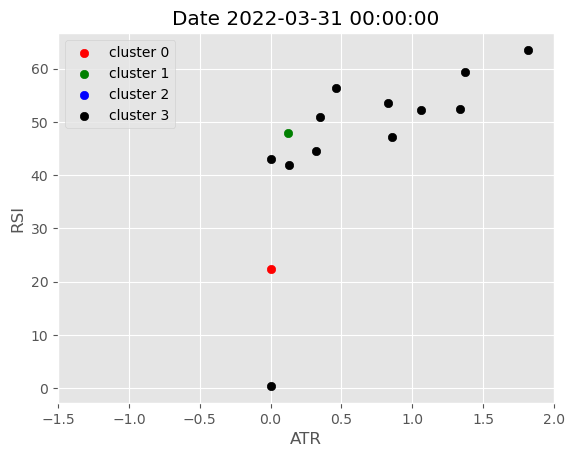

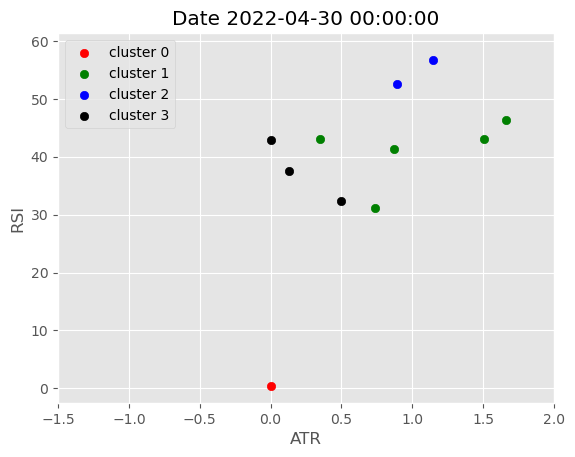

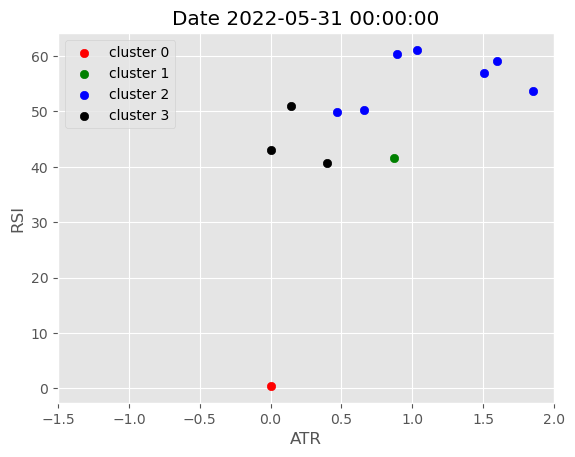

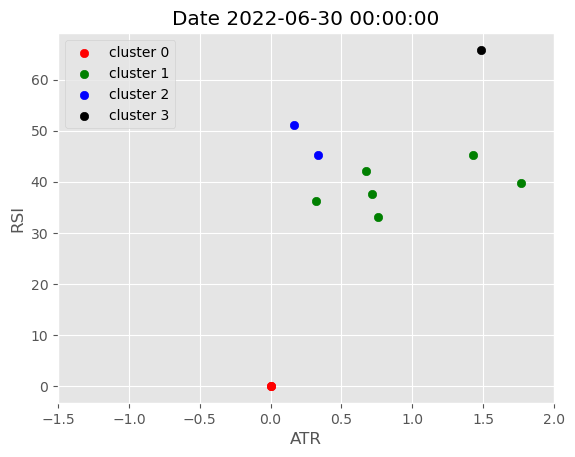

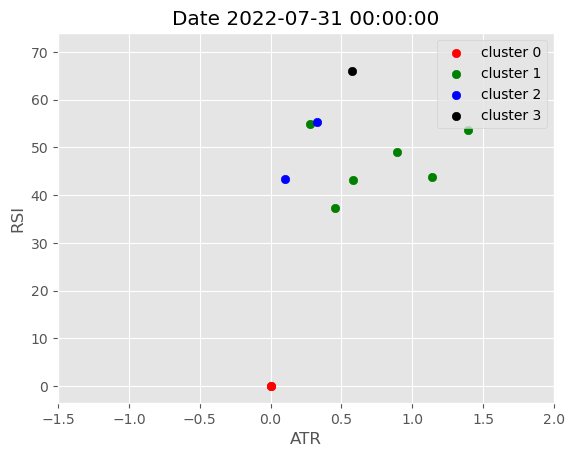

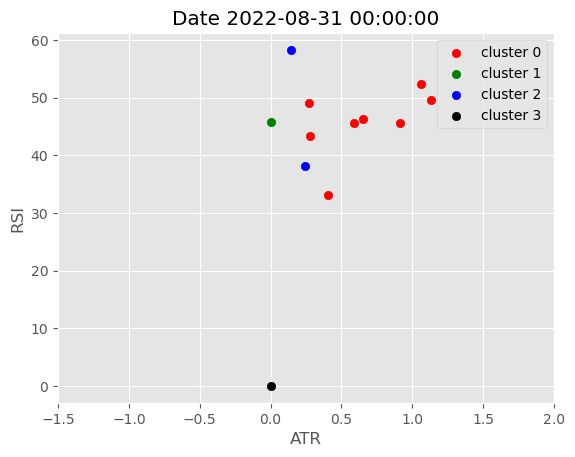

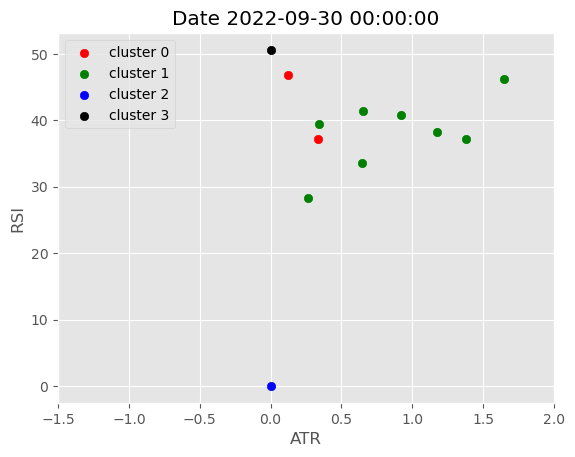

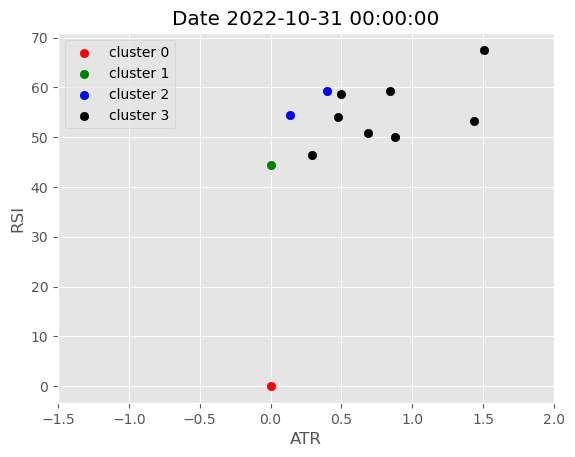

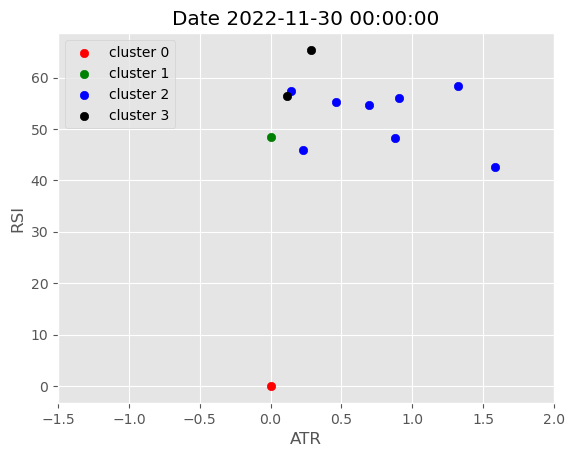

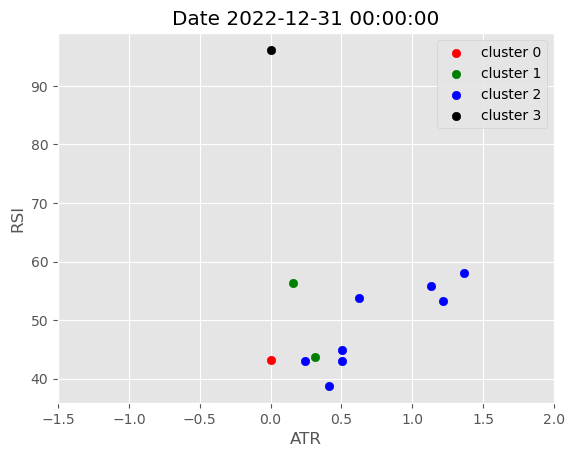

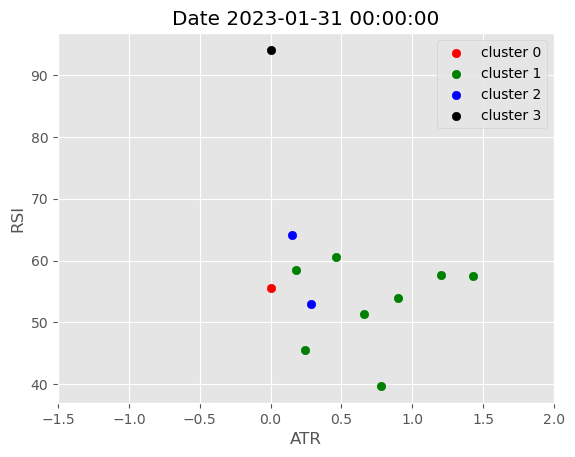

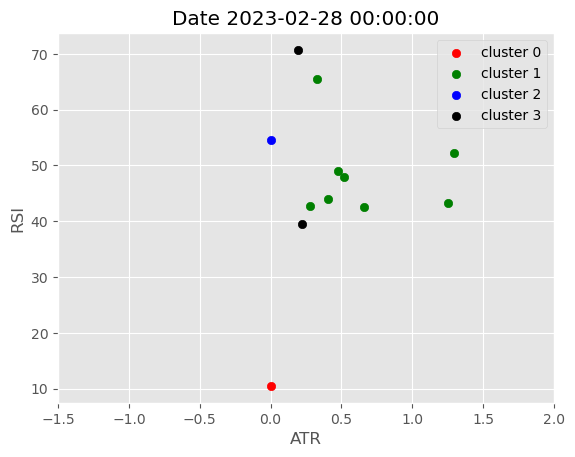

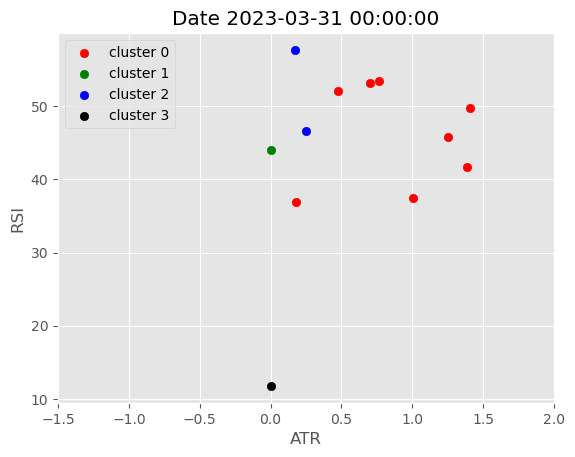

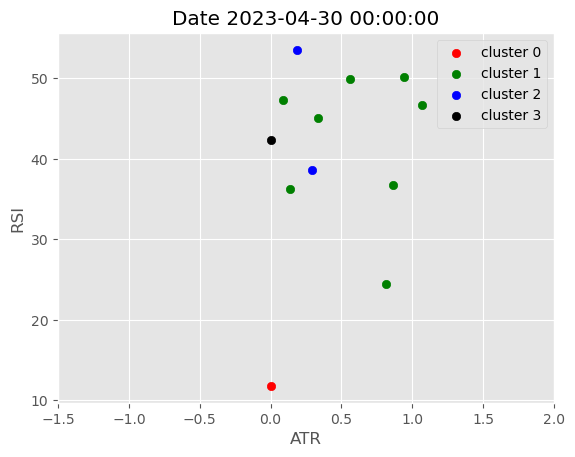

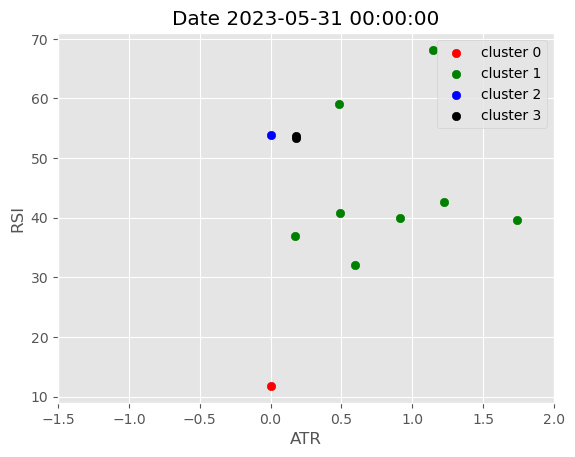

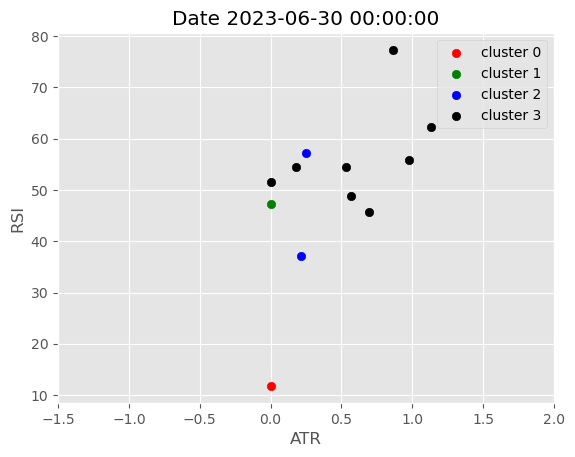

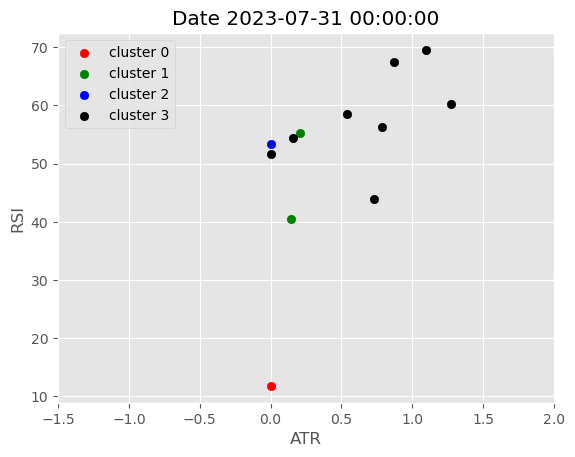

In [16]:
#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.xlim(-1.5, 2)
    plt.xlabel('ATR')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [17]:
#For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.

filtered_df = data[data['cluster']==2].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-08-01': ['INFY', 'ITI'],
 '2017-09-01': ['IEX'],
 '2017-10-01': ['ITI'],
 '2017-11-01': ['INFY', 'ITI'],
 '2017-12-01': ['KSB'],
 '2018-01-01': ['INFY'],
 '2018-02-01': ['BDL',
  'CCL',
  'HAL',
  'IDEA',
  'IEX',
  'INFY',
  'MMTC',
  'NCC',
  'OIL',
  'PFC',
  'RBA',
  'TCI',
  'TCS',
  'MCX'],
 '2018-03-01': ['ITC'],
 '2018-04-01': ['KSB', 'MCX'],
 '2018-05-01': ['MMTC', 'NCC', 'OIL', 'PFC', 'RBA', 'TCI', 'TCS'],
 '2018-06-01': ['BDL', 'CCL', 'HAL', 'IDEA', 'IEX', 'INFY', 'ITI'],
 '2018-07-01': ['KSB', 'MCX'],
 '2018-08-01': ['KSB', 'MCX'],
 '2018-09-01': ['ITC'],
 '2018-10-01': ['ITC'],
 '2018-11-01': ['BDL', 'CCL', 'HAL', 'IDEA', 'IEX', 'INFY', 'ITI'],
 '2018-12-01': ['ITC'],
 '2019-01-01': ['MMTC', 'NCC', 'OIL', 'PFC', 'RBA', 'TCI', 'TCS'],
 '2019-02-01': ['BDL',
  'CCL',
  'HAL',
  'IDEA',
  'IEX',
  'INFY',
  'ITI',
  'MMTC',
  'NCC',
  'OIL',
  'PFC',
  'RBA',
  'TCI',
  'TCS'],
 '2019-03-01': ['ITC'],
 '2019-04-01': ['ITC'],
 '2019-05-01': ['BDL',
  'CCL',
  'HAL',
  '

In [18]:
#Define portfolio optimization function.


from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [19]:
#Download Fresh Daily Prices Data only for short listed stocks.

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  17 of 17 completed


Price       Adj Close                                                      \
Ticker            BDL        CCL        HAL   IDEA         IEX       INFY   
Date                                                                        
2016-08-01  21.839252  41.326046  36.813980  0.009   82.196312   6.794093   
2016-08-02  21.947817  40.043186  36.622414  0.009   81.922302   6.720289   
2016-08-03  22.065424  40.370537  37.388653  0.009   82.196312   6.703888   
2016-08-04  22.065424  40.839447  37.432182  0.009   82.470299   6.597282   
2016-08-05  22.065424  41.626865  38.059105  0.009   83.200943   6.662886   
...               ...        ...        ...    ...         ...        ...   
2023-07-24  30.450001  17.850000  37.755081  0.026  213.538239  16.011208   
2023-07-25  30.450001  17.450001  37.912968  0.027  209.194901  16.169147   
2023-07-26  30.450001  17.650000  37.705738  0.026  210.685745  16.406061   
2023-07-27  29.799999  18.219999  37.429436  0.026  217.483978  16.415930   
2023-07-28  29.549999  18.490000  37.656399  0.027  220.883102  16.248119   

Price                                                    ...  Volume  \
Ticker               ITC   ITI           KSB        MCX  ...     ITI   
Date                                                     ...           
2016-08-01     33.174900  3.39  33181.800781  19.248669  ...   56700   
2016-08-02     33.601101  3.34  30909.099609  19.210773  ...   44400   
2016-08-03     33.103802  3.40  28863.599609  19.172884  ...   72400   
2016-08-04     32.819698  3.41  29090.900391  19.210773  ...  104100   
2016-08-05  10800.000000  3.24  29772.699219  19.278984  ...  143800   
...                  ...   ...           ...        ...  ...     ...   
2023-07-24           NaN  4.00           NaN        NaN  ...  110200   
2023-07-25           NaN  3.97           NaN        NaN  ...   63900   
2023-07-26           NaN  3.93           NaN        NaN  ...   71700   
2023-07-27           NaN  3.86           NaN        NaN  ...   72100   
2023-07-28           NaN  3.87           NaN        NaN  ...   48900   

Price                                                                      \
Ticker            KSB     MCX   MMTC  NCC      OIL     PFC      RBA   TCI   
Date                                                                        
2016-08-01   569536.0  4600.0    660  0.0  16247.0   32400   168400     0   
2016-08-02  1102574.0  2700.0  10500  0.0   3002.0   66000   640100     0   
2016-08-03  2160598.0  2600.0   3418  0.0   3703.0   56600   958700     0   
2016-08-04  1127368.0   600.0    883  0.0   2320.0   50800   556200     0   
2016-08-05   465542.0  1200.0  15672  0.0   2370.0   52200   677300   300   
...               ...     ...    ...  ...      ...     ...      ...   ...   
2023-07-24        NaN     NaN      0  NaN      NaN  150000   602300   800   
2023-07-25        NaN     NaN      0  NaN      NaN  179800   810300   600   
2023-07-26        NaN     NaN      0  NaN      NaN  447400   612700  3300   
2023-07-27        NaN     NaN      0  NaN      NaN  225400   833400  2200   
2023-07-28        NaN     NaN      0  NaN      NaN  156300  1487100  2500   

Price               
Ticker         TCS  
Date                
2016-08-01  460200  
2016-08-02  343900  
2016-08-03  168600  
2016-08-04  145700  
2016-08-05  131700  
...            ...  
2023-07-24  355400  
2023-07-25  341300  
2023-07-26  284600  
2023-07-27  285100  
2023-07-28  223700  

[1760 rows x 102 columns]

In [20]:
# Create a new DataFrame for 'Adj Close' columns
adj_close_df = new_df.filter(like='Adj Close')
# Set the 'Adj Close' level in the MultiIndex
adj_close_df.columns = pd.MultiIndex.from_product([['Adj Close'], adj_close_df.columns.get_level_values(1)])

# Create a new DataFrame for 'Volume' columns
volume_df = new_df.filter(like='Volume')
# Set the 'Volume' level in the MultiIndex
volume_df.columns = pd.MultiIndex.from_product([['Volume'], volume_df.columns.get_level_values(1)])

# Concatenate the two DataFrames along the columns axis
new_df = pd.concat([adj_close_df, volume_df], axis=1)

# Display the new DataFrame
print(new_df)

            Adj Close                                                      \
Ticker            BDL        CCL        HAL   IDEA         IEX       INFY   
Date                                                                        
2016-08-01  21.839252  41.326046  36.813980  0.009   82.196312   6.794093   
2016-08-02  21.947817  40.043186  36.622414  0.009   81.922302   6.720289   
2016-08-03  22.065424  40.370537  37.388653  0.009   82.196312   6.703888   
2016-08-04  22.065424  40.839447  37.432182  0.009   82.470299   6.597282   
2016-08-05  22.065424  41.626865  38.059105  0.009   83.200943   6.662886   
...               ...        ...        ...    ...         ...        ...   
2023-07-24  30.450001  17.850000  37.755081  0.026  213.538239  16.011208   
2023-07-25  30.450001  17.450001  37.912968  0.027  209.194901  16.169147   
2023-07-26  30.450001  17.650000  37.705738  0.026  210.685745  16.406061   
2023-07-27  29.799999  18.219999  37.429436  0.026  217.483978  16.415930   

In [21]:
#Calculate daily returns for each stock which could land up in our portfolio. Then loop over each month start, select the stocks for the month and calculate their weights for the next month. If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights. Calculated each day portfolio return.

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-08-01         0.028280
2017-08-02        -0.015579
2017-08-03         0.017175
2017-08-04         0.004974
2017-08-07        -0.021370
...                     ...
2023-07-24         0.006844
2023-07-25        -0.006087
2023-07-26         0.003840
2023-07-27         0.004796
2023-07-28         0.002607

[1336 rows x 1 columns]

In [22]:
#Visualize Portfolio returns and compare to NIFTY500 returns.

# Download NIFTY 500 data
nifty500 = yf.download(tickers='^NSEI',
                       start='2018-01-01',
                       end=dt.date.today())

# Calculate NIFTY 500 returns
nifty500_ret = np.log(nifty500['Adj Close']).diff().dropna().rename('NIFTY 500 Buy&Hold')

# Merge NIFTY 500 returns with your existing DataFrame (portfolio_df)
portfolio_df = portfolio_df.merge(nifty500_ret,
                                  left_index=True,
                                  right_index=True)

# Display the updated DataFrame
portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  NIFTY 500 Buy&Hold
2018-01-03        -0.008632            0.000096
2018-01-04        -0.006211            0.005881
2018-01-05         0.018519            0.005132
2018-01-08         0.007920            0.006114
2018-01-09         0.015653            0.001261
...                     ...                 ...
2023-07-24         0.006844           -0.003686
2023-07-25        -0.006087            0.000419
2023-07-26         0.003840            0.004952
2023-07-27         0.004796           -0.006004
2023-07-28         0.002607           -0.000705

[1175 rows x 2 columns]

In [32]:
#Calculating Highest Strategy Return through-out.

highest_return = portfolio_df['Strategy Return'].max()
print("Highest Strategy Return:", highest_return)

Highest Strategy Return: 8.49568700986804


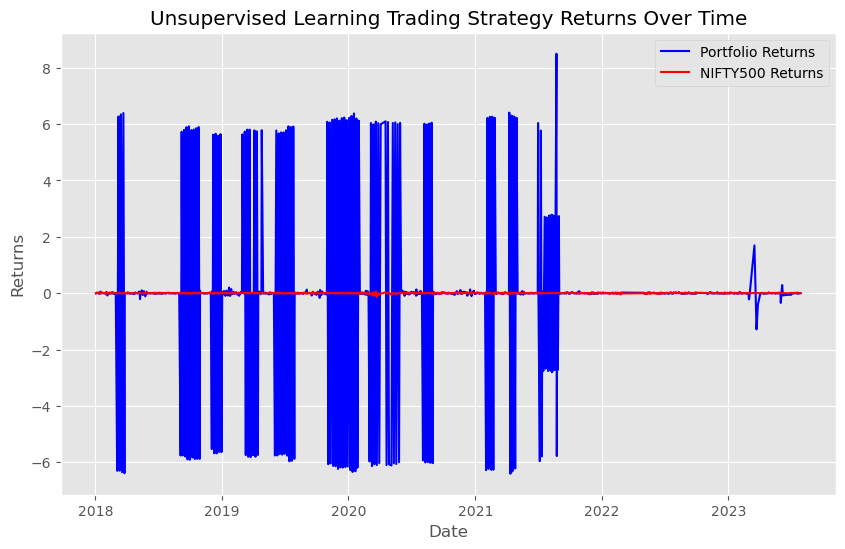

In [38]:
portfolio_returns = portfolio_df['Strategy Return']
nifty500_returns = portfolio_df['NIFTY 500 Buy&Hold']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns.index, portfolio_returns, label='Portfolio Returns', color='blue')
plt.plot(nifty500_returns.index, nifty500_returns, label='NIFTY500 Returns', color='red')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()

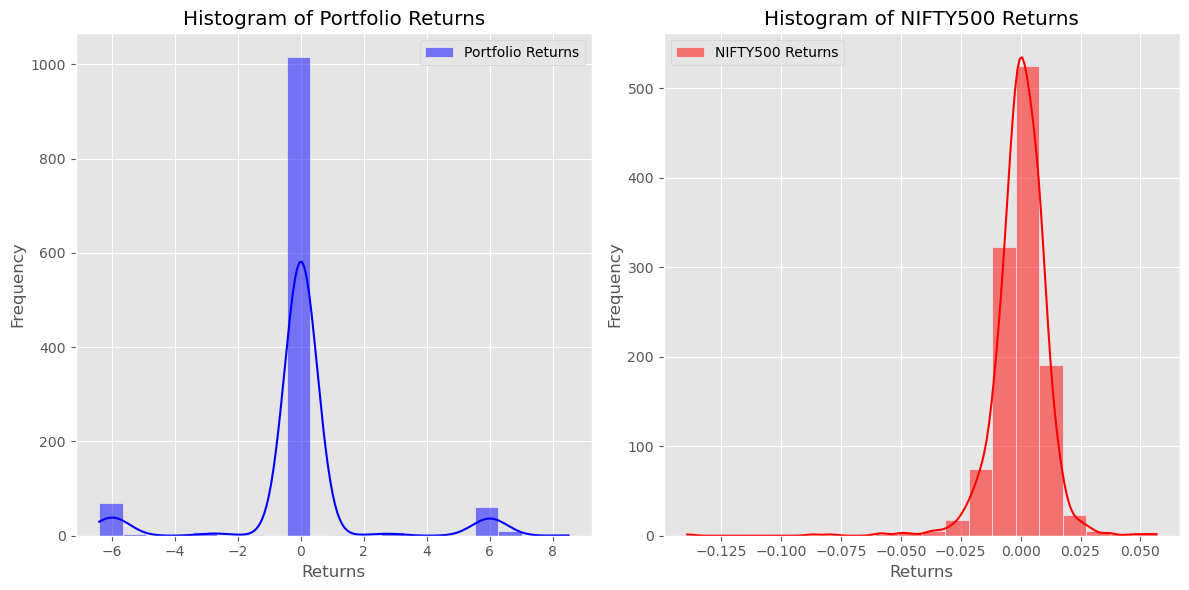

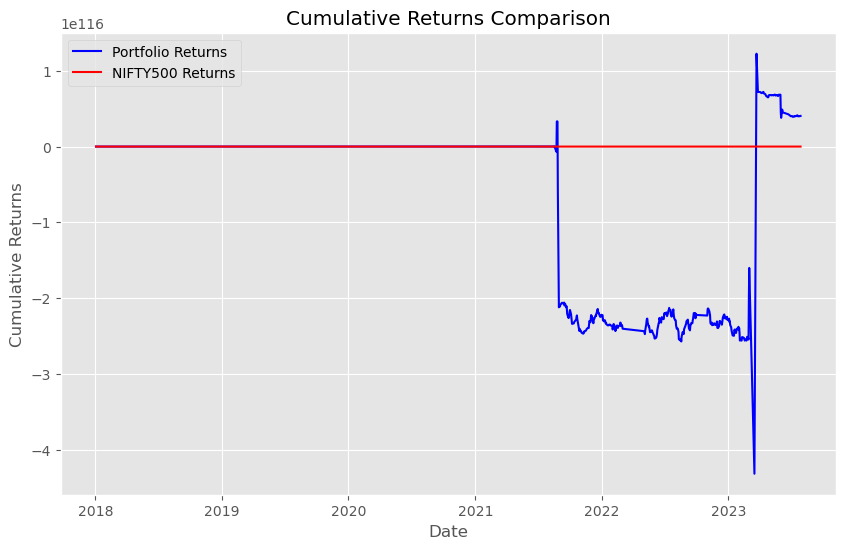

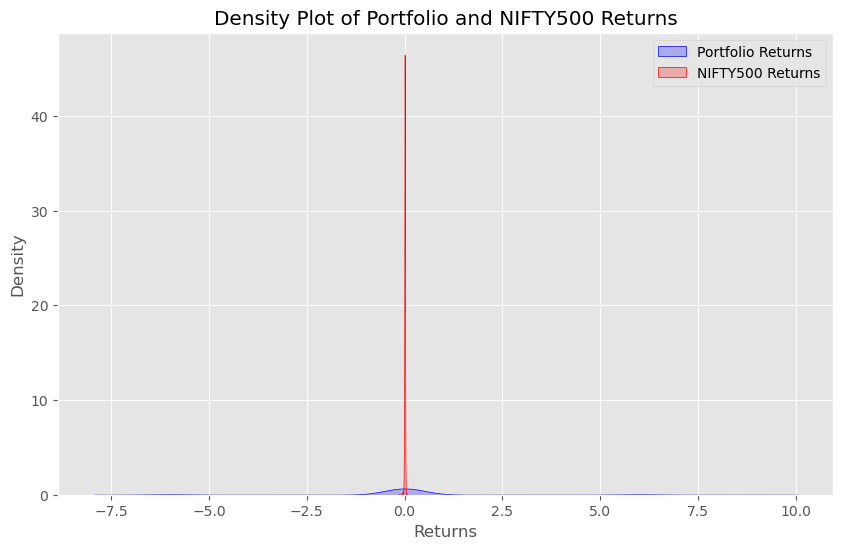

In [31]:
# Histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(portfolio_returns, color='blue', kde=True, label='Portfolio Returns', bins=20)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Portfolio Returns')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(nifty500_returns, color='red', kde=True, label='NIFTY500 Returns', bins=20)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of NIFTY500 Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Cumulative Returns
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
cumulative_nifty500_returns = (1 + nifty500_returns).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Portfolio Returns', color='blue')
plt.plot(cumulative_nifty500_returns.index, cumulative_nifty500_returns, label='NIFTY500 Returns', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(portfolio_returns, color='blue', label='Portfolio Returns', shade=True)
sns.kdeplot(nifty500_returns, color='red', label='NIFTY500 Returns', shade=True)
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Density Plot of Portfolio and NIFTY500 Returns')
plt.legend()
plt.grid(True)
plt.show()